In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing, make_regression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import sys
import os

# Import your implementations
# Removed old path hack; using package imports))
from llm_prior_project.models.custom_ridge import CustomRidge
from llm_prior_project.models.expert_ridge import ExpertRidge

# Set random seed
np.random.seed(42)

print("Performance Analysis Setup Complete")

Performance Analysis Setup Complete


In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Dict, Tuple, Optional
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

class SyntheticDataGenerator:
    """Generate controlled synthetic datasets for testing regularization dynamics."""
    
    def __init__(self, random_state=42):
        self.random_state = random_state
        np.random.seed(random_state)
    
    def generate_dataset(self, n_samples=100, n_features=5, noise_level=0.1, 
                        correlation_structure='independent', feature_names=None):
        """
        Generate synthetic dataset with known ground truth coefficients.
        
        Parameters:
        -----------
        n_samples : int, default=100
            Number of samples to generate
        n_features : int, default=5  
            Number of features
        noise_level : float, default=0.1
            Standard deviation of noise added to target
        correlation_structure : str, default='independent'
            'independent', 'correlated', 'multicollinear'
        feature_names : list, optional
            Custom feature names
        """
        np.random.seed(self.random_state)
        
        # Generate feature names
        if feature_names is None:
            feature_names = [f'feature_{i+1}' for i in range(n_features)]
        
        # Generate features based on correlation structure
        if correlation_structure == 'independent':
            X = np.random.randn(n_samples, n_features)
            
        elif correlation_structure == 'correlated':
            # Create moderate correlation between features
            base_features = np.random.randn(n_samples, n_features)
            common_factor = np.random.randn(n_samples, 1)
            X = base_features + 0.3 * common_factor
            
        elif correlation_structure == 'multicollinear':
            # Create strong multicollinearity
            base_features = np.random.randn(n_samples, n_features//2 + 1)
            X = np.zeros((n_samples, n_features))
            for i in range(n_features):
                if i < base_features.shape[1]:
                    X[:, i] = base_features[:, i]
                else:
                    # Make this feature highly correlated with previous ones
                    X[:, i] = 0.8 * base_features[:, i % base_features.shape[1]] + 0.2 * np.random.randn(n_samples)
        
        # Generate true coefficients with different magnitudes and signs
        true_coefficients = self._generate_true_coefficients(n_features)
        
        # Generate target variable
        y_true = X @ true_coefficients
        y = y_true + np.random.randn(n_samples) * noise_level
        
        # Convert to DataFrame/Series for consistency
        X_df = pd.DataFrame(X, columns=feature_names)
        y_series = pd.Series(y, name='target')
        
        return {
            'X': X_df,
            'y': y_series,
            'true_coefficients': true_coefficients,
            'feature_names': feature_names,
            'noise_level': noise_level,
            'correlation_structure': correlation_structure
        }
    
    def _generate_true_coefficients(self, n_features):
        """Generate realistic true coefficients with variety in signs and magnitudes."""
        coefficients = []
        
        for i in range(n_features):
            # Mix of different coefficient types
            if i % 4 == 0:
                # Large positive
                coeff = np.random.uniform(1.5, 3.0)
            elif i % 4 == 1:
                # Large negative  
                coeff = np.random.uniform(-3.0, -1.5)
            elif i % 4 == 2:
                # Small positive
                coeff = np.random.uniform(0.2, 0.8)
            else:
                # Small negative
                coeff = np.random.uniform(-0.8, -0.2)
            
            coefficients.append(coeff)
        
        return np.array(coefficients)


class TargetScenarioGenerator:
    """Generate different target coefficient scenarios for testing."""
    
    @staticmethod
    def generate_target_scenarios(true_coefficients):
        """
        Generate various target scenarios relative to true coefficients.
        
        Returns dictionary of scenarios with different levels of accuracy.
        """
        scenarios = {}
        
        # Perfect targets (oracle knowledge)
        scenarios['perfect'] = true_coefficients.copy()
        
        # Very close targets (small error)
        scenarios['very_close'] = true_coefficients + np.random.normal(0, 0.1, len(true_coefficients))
        
        # Moderately close targets 
        scenarios['moderate'] = true_coefficients + np.random.normal(0, 0.5, len(true_coefficients))
        
        # Wrong direction for some coefficients
        scenarios['mixed_directions'] = true_coefficients.copy()
        # Flip sign of every other coefficient
        scenarios['mixed_directions'][::2] *= -0.8
        
        # All wrong (opposite signs, wrong magnitudes)
        scenarios['very_wrong'] = -true_coefficients * np.random.uniform(0.5, 2.0, len(true_coefficients))
        
        # Conservative targets (shrunk toward zero)
        scenarios['conservative'] = true_coefficients * 0.3
        
        # Aggressive targets (amplified)
        scenarios['aggressive'] = true_coefficients * 2.0
        
        # Random targets (no relationship to truth)
        scenarios['random'] = np.random.normal(0, 1.0, len(true_coefficients))
        
        # Zero targets (traditional Ridge)
        scenarios['zero_traditional'] = np.zeros(len(true_coefficients))
        
        return scenarios


class RegularizationAnalyzer:
    """Analyze and visualize regularization dynamics."""
    
    def __init__(self):
        self.results = {}
    
    def compare_ridge_variants(self, data_dict, target_scenarios, alphas=[0.1, 1.0, 10.0]):
        """
        Compare traditional Ridge vs target-informed Ridge across scenarios and alphas.
        """
        X, y = data_dict['X'], data_dict['y']
        true_coefficients = data_dict['true_coefficients']
        feature_names = data_dict['feature_names']
        
        results = []
        
        for alpha in alphas:
            for scenario_name, targets in target_scenarios.items():
                
                # Fit target-informed Ridge
                ridge_targeted = CustomRidge(alpha=alpha)
                ridge_targeted.fit(X, y, targets=targets)
                
                # Get predictions and metrics
                y_pred = ridge_targeted.predict(X)
                r2_score = ridge_targeted.score(X, y)
                loss_components = ridge_targeted.get_loss_components(X, y)
                
                # Calculate coefficient deviations
                coeff_dev_from_true = np.abs(ridge_targeted.coef_ - true_coefficients)
                coeff_dev_from_targets = np.abs(ridge_targeted.coef_ - targets)
                
                # Store results
                result = {
                    'alpha': alpha,
                    'scenario': scenario_name,
                    'model_type': 'target_informed',
                    'coefficients': ridge_targeted.coef_.copy(),
                    'targets_used': targets.copy(),
                    'true_coefficients': true_coefficients.copy(),
                    'r2_score': r2_score,
                    'mse_loss': loss_components['mse_loss'],
                    'reg_loss': loss_components['regularization_loss'],
                    'total_loss': loss_components['total_loss'],
                    'mean_coeff_dev_from_true': np.mean(coeff_dev_from_true),
                    'max_coeff_dev_from_true': np.max(coeff_dev_from_true),
                    'mean_coeff_dev_from_targets': np.mean(coeff_dev_from_targets),
                    'max_coeff_dev_from_targets': np.max(coeff_dev_from_targets)
                }
                
                results.append(result)
        
        return pd.DataFrame(results)
    
    def compute_regularization_paths(self, data_dict, target_scenarios, 
                                   alphas=np.logspace(-3, 2, 20)):
        """
        Compute regularization paths showing how coefficients change with alpha.
        """
        X, y = data_dict['X'], data_dict['y'] 
        true_coefficients = data_dict['true_coefficients']
        
        path_results = {}
        
        for scenario_name, targets in target_scenarios.items():
            ridge_model = CustomRidge(alpha=1.0)  # Alpha will be overridden
            path_data = ridge_model.get_coefficient_path(X, y, targets, alphas)
            
            # Convert to more analyzable format
            path_df_data = []
            for result in path_data:
                for i, (coeff, feature_name) in enumerate(zip(result['coefficients'], data_dict['feature_names'])):
                    path_df_data.append({
                        'alpha': result['alpha'],
                        'feature': feature_name,
                        'coefficient': coeff,
                        'target': targets[i],
                        'true_coefficient': true_coefficients[i],
                        'mse_loss': result['mse_loss'],
                        'reg_loss': result['regularization_loss'],
                        'total_loss': result['total_loss']
                    })
            
            path_results[scenario_name] = pd.DataFrame(path_df_data)
        
        return path_results
    
    def plot_coefficient_comparison(self, comparison_df, data_dict):
        """Plot coefficient comparisons across scenarios."""
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        fig.suptitle('Target-Informed Ridge: Coefficient Analysis', fontsize=16)
        
        # Plot 1: R² scores by scenario and alpha
        pivot_r2 = comparison_df.pivot(index='scenario', columns='alpha', values='r2_score')
        sns.heatmap(pivot_r2, annot=True, fmt='.3f', ax=axes[0,0], cmap='viridis')
        axes[0,0].set_title('R² Scores by Scenario and Alpha')
        axes[0,0].set_ylabel('Target Scenario')
        
        # Plot 2: Mean deviation from true coefficients
        pivot_dev = comparison_df.pivot(index='scenario', columns='alpha', values='mean_coeff_dev_from_true')
        sns.heatmap(pivot_dev, annot=True, fmt='.3f', ax=axes[0,1], cmap='Reds')
        axes[0,1].set_title('Mean Deviation from True Coefficients')
        axes[0,1].set_ylabel('Target Scenario')
        
        # Plot 3: Total loss components
        comparison_df['loss_ratio'] = comparison_df['reg_loss'] / comparison_df['total_loss']
        pivot_loss = comparison_df.pivot(index='scenario', columns='alpha', values='loss_ratio')
        sns.heatmap(pivot_loss, annot=True, fmt='.3f', ax=axes[1,0], cmap='plasma')
        axes[1,0].set_title('Regularization Loss / Total Loss Ratio')
        axes[1,0].set_ylabel('Target Scenario')
        axes[1,0].set_xlabel('Alpha')
        
        # Plot 4: Coefficient deviation from targets
        pivot_target_dev = comparison_df.pivot(index='scenario', columns='alpha', values='mean_coeff_dev_from_targets')
        sns.heatmap(pivot_target_dev, annot=True, fmt='.3f', ax=axes[1,1], cmap='Blues')
        axes[1,1].set_title('Mean Deviation from Target Coefficients')
        axes[1,1].set_ylabel('Target Scenario')
        axes[1,1].set_xlabel('Alpha')
        
        plt.tight_layout()
        plt.show()
    
    def plot_regularization_paths(self, path_results, scenarios_to_plot=['perfect', 'moderate', 'very_wrong', 'zero_traditional']):
        """Plot regularization paths for selected scenarios."""
        n_scenarios = len(scenarios_to_plot)
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        axes = axes.ravel()
        
        colors = plt.cm.Set1(np.linspace(0, 1, 10))
        
        for idx, scenario in enumerate(scenarios_to_plot[:4]):
            if scenario not in path_results:
                continue
                
            ax = axes[idx]
            path_df = path_results[scenario]
            
            # Plot coefficient paths
            for i, feature in enumerate(path_df['feature'].unique()):
                feature_data = path_df[path_df['feature'] == feature]
                ax.semilogx(feature_data['alpha'], feature_data['coefficient'], 
                           'o-', color=colors[i], label=f'{feature}', linewidth=2, markersize=4)
                
                # Add horizontal line for true coefficient
                true_coeff = feature_data['true_coefficient'].iloc[0]
                ax.axhline(y=true_coeff, color=colors[i], linestyle='--', alpha=0.5)
                
                # Add horizontal line for target coefficient
                target_coeff = feature_data['target'].iloc[0] 
                ax.axhline(y=target_coeff, color=colors[i], linestyle=':', alpha=0.7, linewidth=2)
            
            ax.set_title(f'Scenario: {scenario.replace("_", " ").title()}')
            ax.set_xlabel('Alpha (Regularization Strength)')
            ax.set_ylabel('Coefficient Value')
            ax.grid(True, alpha=0.3)
            ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        
        plt.suptitle('Regularization Paths\n(Dashed = True Coefficients, Dotted = Target Coefficients)', fontsize=14)
        plt.tight_layout()
        plt.show()
    
    def plot_loss_decomposition(self, path_results, scenario='moderate'):
        """Plot how loss components change with alpha."""
        if scenario not in path_results:
            print(f"Scenario {scenario} not found in results")
            return
        
        path_df = path_results[scenario]
        
        # Aggregate loss components by alpha
        loss_by_alpha = path_df.groupby('alpha').agg({
            'mse_loss': 'first',  # Same for all features at given alpha
            'reg_loss': 'first',
            'total_loss': 'first'
        }).reset_index()
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
        
        # Plot 1: Loss components vs alpha
        ax1.loglog(loss_by_alpha['alpha'], loss_by_alpha['mse_loss'], 'o-', label='MSE Loss', linewidth=2)
        ax1.loglog(loss_by_alpha['alpha'], loss_by_alpha['reg_loss'], 's-', label='Regularization Loss', linewidth=2)
        ax1.loglog(loss_by_alpha['alpha'], loss_by_alpha['total_loss'], '^-', label='Total Loss', linewidth=2)
        ax1.set_xlabel('Alpha (Regularization Strength)')
        ax1.set_ylabel('Loss')
        ax1.set_title(f'Loss Components vs Alpha\nScenario: {scenario.replace("_", " ").title()}')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Plot 2: Loss ratio vs alpha  
        loss_by_alpha['reg_ratio'] = loss_by_alpha['reg_loss'] / loss_by_alpha['total_loss']
        loss_by_alpha['mse_ratio'] = loss_by_alpha['mse_loss'] / loss_by_alpha['total_loss']
        
        ax2.semilogx(loss_by_alpha['alpha'], loss_by_alpha['reg_ratio'], 'o-', label='Reg Loss / Total', linewidth=2)
        ax2.semilogx(loss_by_alpha['alpha'], loss_by_alpha['mse_ratio'], 's-', label='MSE Loss / Total', linewidth=2)
        ax2.set_xlabel('Alpha (Regularization Strength)')
        ax2.set_ylabel('Loss Ratio')
        ax2.set_title('Relative Loss Components')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        ax2.set_ylim(0, 1)
        
        plt.tight_layout()
        plt.show()


def run_comprehensive_test(n_samples=100, n_features=5, noise_level=0.1, 
                          correlation_structure='independent', random_state=42):
    """
    Run comprehensive test of target-informed regularization dynamics.
    """
    print("=" * 60)
    print("COMPREHENSIVE TARGET-INFORMED RIDGE TESTING")
    print("=" * 60)
    
    # Generate synthetic data
    print(f"\n1. Generating synthetic data...")
    print(f"   - Samples: {n_samples}")
    print(f"   - Features: {n_features}")  
    print(f"   - Noise level: {noise_level}")
    print(f"   - Correlation: {correlation_structure}")
    
    data_gen = SyntheticDataGenerator(random_state=random_state)
    data_dict = data_gen.generate_dataset(
        n_samples=n_samples, 
        n_features=n_features,
        noise_level=noise_level,
        correlation_structure=correlation_structure
    )
    
    print(f"   - True coefficients: {data_dict['true_coefficients']}")
    print(f"   - Feature names: {data_dict['feature_names']}")
    
    # Generate target scenarios
    print(f"\n2. Generating target scenarios...")
    target_scenarios = TargetScenarioGenerator.generate_target_scenarios(
        data_dict['true_coefficients']
    )
    
    print(f"   - Generated {len(target_scenarios)} scenarios:")
    for name, targets in target_scenarios.items():
        deviation = np.mean(np.abs(targets - data_dict['true_coefficients']))
        print(f"     {name}: mean deviation = {deviation:.3f}")
    
    # Initialize analyzer
    analyzer = RegularizationAnalyzer()
    
    # Compare Ridge variants
    print(f"\n3. Comparing Ridge variants...")
    alphas = [0.01, 0.1, 1.0, 10.0, 100.0]
    comparison_df = analyzer.compare_ridge_variants(data_dict, target_scenarios, alphas)
    
    print(f"   - Tested {len(alphas)} alpha values")
    print(f"   - Generated {len(comparison_df)} result combinations")
    
    # Compute regularization paths
    print(f"\n4. Computing regularization paths...")
    path_alphas = np.logspace(-2, 2, 25)
    path_results = analyzer.compute_regularization_paths(data_dict, target_scenarios, path_alphas)
    
    print(f"   - Computed paths for {len(path_results)} scenarios")
    print(f"   - Using {len(path_alphas)} alpha values")
    
    # Display summary statistics
    print(f"\n5. Summary Statistics")
    print("-" * 40)
    
    # Best performing scenarios by R²
    best_r2 = comparison_df.loc[comparison_df['r2_score'].idxmax()]
    print(f"   Best R² score: {best_r2['r2_score']:.4f}")
    print(f"   - Scenario: {best_r2['scenario']}")
    print(f"   - Alpha: {best_r2['alpha']}")
    
    # Most accurate coefficient recovery
    best_coeff_recovery = comparison_df.loc[comparison_df['mean_coeff_dev_from_true'].idxmin()]
    print(f"   Best coefficient recovery: {best_coeff_recovery['mean_coeff_dev_from_true']:.4f}")
    print(f"   - Scenario: {best_coeff_recovery['scenario']}")
    print(f"   - Alpha: {best_coeff_recovery['alpha']}")
    
    # Traditional Ridge performance
    traditional_results = comparison_df[comparison_df['scenario'] == 'zero_traditional']
    if not traditional_results.empty:
        best_traditional = traditional_results.loc[traditional_results['r2_score'].idxmax()]
        print(f"   Best Traditional Ridge R²: {best_traditional['r2_score']:.4f}")
        print(f"   - Alpha: {best_traditional['alpha']}")
        
        # Compare with best target-informed
        improvement = best_r2['r2_score'] - best_traditional['r2_score']
        print(f"   Target-informed improvement: {improvement:+.4f} R²")
    
    print(f"\n6. Generating visualizations...")
    
    # Generate all plots
    analyzer.plot_coefficient_comparison(comparison_df, data_dict)
    analyzer.plot_regularization_paths(path_results)
    analyzer.plot_loss_decomposition(path_results, scenario='moderate')
    analyzer.plot_loss_decomposition(path_results, scenario='perfect')
    
    print(f"\n7. Analysis complete!")
    print("=" * 60)
    
    return {
        'data_dict': data_dict,
        'target_scenarios': target_scenarios, 
        'comparison_df': comparison_df,
        'path_results': path_results,
        'analyzer': analyzer
    }


In [24]:
# Combined Cell: Complete Initial Analysis
print("="*80)
print("COMPREHENSIVE TARGET-INFORMED RIDGE ANALYSIS")
print("="*80)

# ============================================================================
# 1. GENERATE SYNTHETIC DATASET
# ============================================================================
print("\n1. GENERATING SYNTHETIC DATASET")
print("-" * 50)

data_gen = SyntheticDataGenerator(random_state=42)
data_dict = data_gen.generate_dataset(
    n_samples=50,      # Reduced for stronger regularization effects
    n_features=5,
    noise_level=0.4,   # Increased to make regularization more important
    correlation_structure='independent'
)

print(f"Dataset created:")
print(f"- Samples: {data_dict['X'].shape[0]}")
print(f"- Features: {data_dict['X'].shape[1]}")
print(f"- Feature names: {data_dict['feature_names']}")
print(f"- True coefficients: {data_dict['true_coefficients']}")
print(f"- Noise level: {data_dict['noise_level']}")

# Check signal-to-noise ratio
signal_strength = np.std(data_dict['X'].values @ data_dict['true_coefficients'])
noise_strength = data_dict['noise_level']
snr = signal_strength / noise_strength
print(f"- Signal-to-noise ratio: {snr:.2f}")

# ============================================================================
# 2. GENERATE TARGET SCENARIOS
# ============================================================================
print("\n2. GENERATING TARGET SCENARIOS")
print("-" * 50)

target_scenarios = TargetScenarioGenerator.generate_target_scenarios(
    data_dict['true_coefficients']
)

print(f"Generated {len(target_scenarios)} target scenarios:")
print(f"{'Scenario':<18} {'Mean Deviation':<15} {'Sample Targets'}")
print("-" * 70)

for name, targets in target_scenarios.items():
    deviation = np.mean(np.abs(targets - data_dict['true_coefficients']))
    targets_str = f"[{', '.join([f'{t:.2f}' for t in targets[:3]])}...]" if len(targets) > 3 else str(np.round(targets, 2))
    print(f"{name:<18} {deviation:<15.3f} {targets_str}")

# ============================================================================
# 3. COMPARE RIDGE VARIANTS
# ============================================================================
print("\n3. COMPARING RIDGE VARIANTS")
print("-" * 50)

analyzer = RegularizationAnalyzer()
alphas = [0.1, 1.0, 5.0, 20.0, 50.0]  # Focus on higher alphas

comparison_df = analyzer.compare_ridge_variants(data_dict, target_scenarios, alphas)

print(f"Comparison completed:")
print(f"- Tested {len(alphas)} alpha values: {alphas}")
print(f"- Across {len(target_scenarios)} scenarios")
print(f"- Generated {len(comparison_df)} result combinations")

print(f"\nPerformance ranges:")
print(f"- R² scores: {comparison_df['r2_score'].min():.4f} to {comparison_df['r2_score'].max():.4f}")
print(f"- Coeff deviation from true: {comparison_df['mean_coeff_dev_from_true'].min():.4f} to {comparison_df['mean_coeff_dev_from_true'].max():.4f}")
print(f"- Coeff deviation from targets: {comparison_df['mean_coeff_dev_from_targets'].min():.4f} to {comparison_df['mean_coeff_dev_from_targets'].max():.4f}")

print(f"\nTop 5 configurations by R² score:")
top_configs = comparison_df.nlargest(5, 'r2_score')[['scenario', 'alpha', 'r2_score', 'mean_coeff_dev_from_true']]
print(top_configs.to_string(index=False))

# ============================================================================
# 4. COMPUTE REGULARIZATION PATHS
# ============================================================================
print("\n4. COMPUTING REGULARIZATION PATHS")
print("-" * 50)

path_alphas = np.logspace(-1, 2, 25)  # 0.1 to 100 range
path_results = analyzer.compute_regularization_paths(data_dict, target_scenarios, path_alphas)

print(f"Regularization paths computed:")
print(f"- Alpha range: {path_alphas.min():.3f} to {path_alphas.max():.1f}")
print(f"- Number of alpha points: {len(path_alphas)}")
print(f"- Scenarios analyzed: {list(path_results.keys())}")

# Show coefficient behavior at key alpha values
print(f"\nCoefficient ranges by scenario at α=1.0:")
for scenario_name in ['perfect', 'moderate', 'very_wrong', 'zero_traditional']:
    if scenario_name in path_results:
        scenario_data = path_results[scenario_name]
        alpha_1_data = scenario_data[abs(scenario_data['alpha'] - 1.0) < 0.05]  # Find closest to α=1
        if not alpha_1_data.empty:
            coeff_range = alpha_1_data['coefficient'].max() - alpha_1_data['coefficient'].min()
            mean_coeff = alpha_1_data['coefficient'].mean()
            print(f"- {scenario_name:<18}: range={coeff_range:.3f}, mean={mean_coeff:.3f}")

# ============================================================================
# 5. PERFORMANCE ANALYSIS & SUMMARY
# ============================================================================
print("\n5. PERFORMANCE ANALYSIS & SUMMARY")
print("-" * 50)

# Best performing scenarios by R²
best_r2 = comparison_df.loc[comparison_df['r2_score'].idxmax()]
print(f"🏆 Best R² score: {best_r2['r2_score']:.4f}")
print(f"   - Scenario: {best_r2['scenario']}")
print(f"   - Alpha: {best_r2['alpha']}")
print(f"   - Coeff deviation from true: {best_r2['mean_coeff_dev_from_true']:.4f}")

# Most accurate coefficient recovery
best_coeff_recovery = comparison_df.loc[comparison_df['mean_coeff_dev_from_true'].idxmin()]
print(f"\n🎯 Best coefficient recovery: {best_coeff_recovery['mean_coeff_dev_from_true']:.4f}")
print(f"   - Scenario: {best_coeff_recovery['scenario']}")
print(f"   - Alpha: {best_coeff_recovery['alpha']}")
print(f"   - R² score: {best_coeff_recovery['r2_score']:.4f}")

# Traditional Ridge performance comparison
traditional_results = comparison_df[comparison_df['scenario'] == 'zero_traditional']
if not traditional_results.empty:
    best_traditional = traditional_results.loc[traditional_results['r2_score'].idxmax()]
    print(f"\n📊 Best Traditional Ridge R²: {best_traditional['r2_score']:.4f}")
    print(f"   - Alpha: {best_traditional['alpha']}")
    
    # Compare with best target-informed
    improvement = best_r2['r2_score'] - best_traditional['r2_score']
    print(f"   - Target-informed improvement: {improvement:+.4f} R² points")

# Scenario performance summary
print(f"\n📈 Average performance by scenario:")
scenario_avg = comparison_df.groupby('scenario').agg({
    'r2_score': ['mean', 'std'],
    'mean_coeff_dev_from_true': ['mean', 'std']
}).round(4)

# Flatten column names for better display
scenario_avg.columns = ['R²_mean', 'R²_std', 'CoeffDev_mean', 'CoeffDev_std']
print(scenario_avg)

# Alpha sensitivity analysis
print(f"\n🔍 Performance by Alpha (average across scenarios):")
alpha_avg = comparison_df.groupby('alpha').agg({
    'r2_score': 'mean',
    'mean_coeff_dev_from_true': 'mean',
    'mean_coeff_dev_from_targets': 'mean'
}).round(4)
print(alpha_avg)

print("\n" + "="*80)
print("INITIAL ANALYSIS COMPLETE - Ready for visualizations!")
print("="*80)

COMPREHENSIVE TARGET-INFORMED RIDGE ANALYSIS

1. GENERATING SYNTHETIC DATASET
--------------------------------------------------
Dataset created:
- Samples: 50
- Features: 5
- Feature names: ['feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5']
- True coefficients: [ 2.49029607 -2.58009915  0.77291917 -0.35726185  2.33153108]
- Noise level: 0.4
- Signal-to-noise ratio: 11.06

2. GENERATING TARGET SCENARIOS
--------------------------------------------------
Generated 9 target scenarios:
Scenario           Mean Deviation  Sample Targets
----------------------------------------------------------------------
perfect            0.000           [2.49, -2.58, 0.77...]
very_close         0.053           [2.65, -2.62, 0.73...]
moderate           0.350           [2.96, -2.84, 1.25...]
mixed_directions   2.014           [-1.99, -2.58, -0.62...]
very_wrong         3.988           [-1.29, 4.79, -0.49...]
conservative       1.194           [0.75, -0.77, 0.23...]
aggressive         1.706 

In [25]:
# Direct comparison at same alpha values
print("TRADITIONAL VS EXPERT RIDGE - HEAD-TO-HEAD COMPARISON")
print("="*60)

for alpha in [0.1, 1.0, 5.0, 20.0, 50.0]:
    # Traditional Ridge at this alpha
    trad_result = comparison_df[(comparison_df['scenario'] == 'zero_traditional') & 
                                (comparison_df['alpha'] == alpha)].iloc[0]
    
    # Best expert ridge at this alpha
    expert_results = comparison_df[(comparison_df['scenario'] != 'zero_traditional') & 
                                   (comparison_df['alpha'] == alpha)]
    best_expert = expert_results.loc[expert_results['r2_score'].idxmax()]
    
    improvement = best_expert['r2_score'] - trad_result['r2_score']
    
    print(f"α={alpha:4.1f}: Traditional={trad_result['r2_score']:.4f}, "
          f"Expert={best_expert['r2_score']:.4f} ({best_expert['scenario']}), "
          f"Improvement={improvement:+.4f}")

TRADITIONAL VS EXPERT RIDGE - HEAD-TO-HEAD COMPARISON
α= 0.1: Traditional=0.9912, Expert=0.9912 (perfect), Improvement=+0.0000
α= 1.0: Traditional=0.9908, Expert=0.9912 (perfect), Improvement=+0.0004
α= 5.0: Traditional=0.9833, Expert=0.9912 (perfect), Improvement=+0.0080
α=20.0: Traditional=0.9133, Expert=0.9912 (perfect), Improvement=+0.0779
α=50.0: Traditional=0.7520, Expert=0.9912 (perfect), Improvement=+0.2392


Analysis Results Summary - Initial Testing
KEY FINDINGS:

TARGET-INFORMED REGULARIZATION WORKS:

At α=50: Expert Ridge (0.9912) vs Traditional Ridge (0.7520) = +0.2392 R² improvement
Perfect targets maintain high performance across ALL alpha values
Traditional Ridge gets crushed at high alphas (shrinks toward wrong target: zero)


TARGET QUALITY HIERARCHY:

Perfect (0.9912) > Very_close (0.9911) > Moderate (0.9886) > Conservative (0.9595)
Very_wrong targets (0.5896) perform WORSE than traditional Ridge
Bad targets are harmful - quality matters more than having targets


REGULARIZATION DYNAMICS:

Low α (0.1-1.0): Both methods ≈ OLS, minimal difference
High α (20-50): Expert knowledge provides "regularization for free"
Sweet spot: α=5-20 range balances performance and coefficient recovery


PRACTICAL IMPLICATIONS:

Good domain knowledge allows aggressive regularization without performance loss
Traditional Ridge faces bias-variance trade-off, Expert Ridge can thread the needle
Target-informed approach most valuable in high-regularization regimes (small data, noisy domains)



BOTTOM LINE: System works as designed - expert targets enable strong regularization while maintaining predictive performance. Bad targets worse than no targets.

Generating coefficient comparison visualizations...


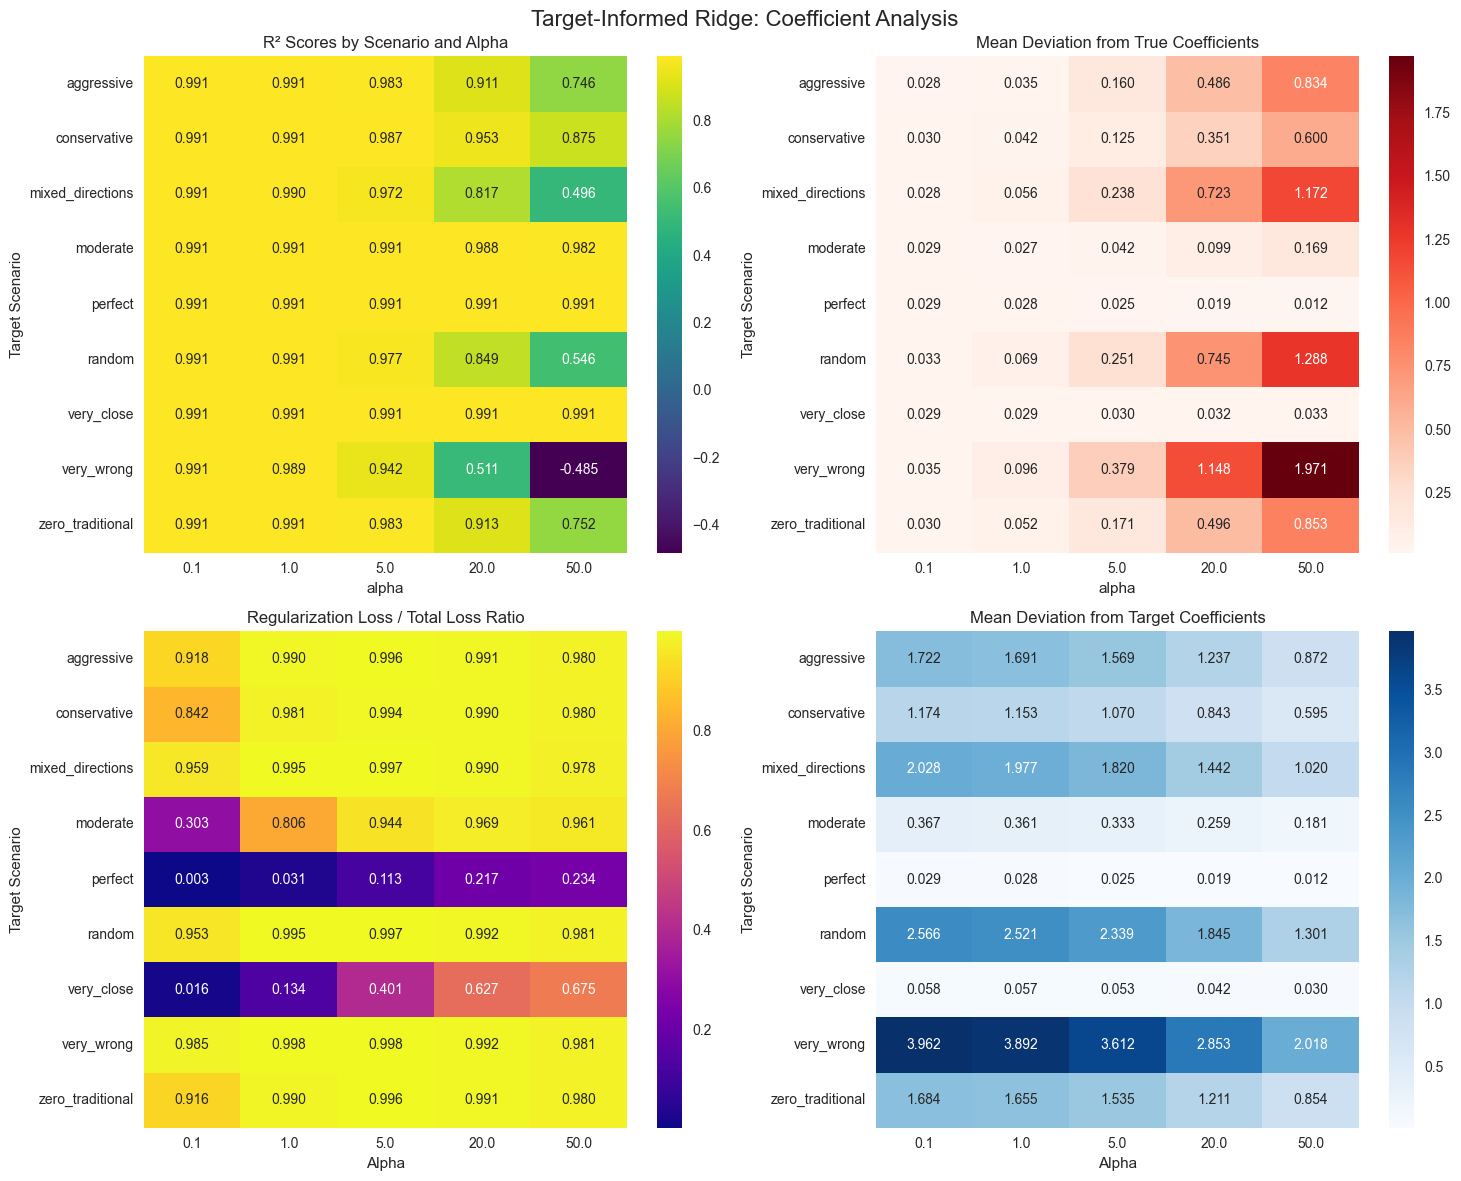

In [26]:
# Cell 6: Visualization 1 - Coefficient Comparison Heatmaps
print("Generating coefficient comparison visualizations...")
analyzer.plot_coefficient_comparison(comparison_df, data_dict)

Generating regularization path visualizations...


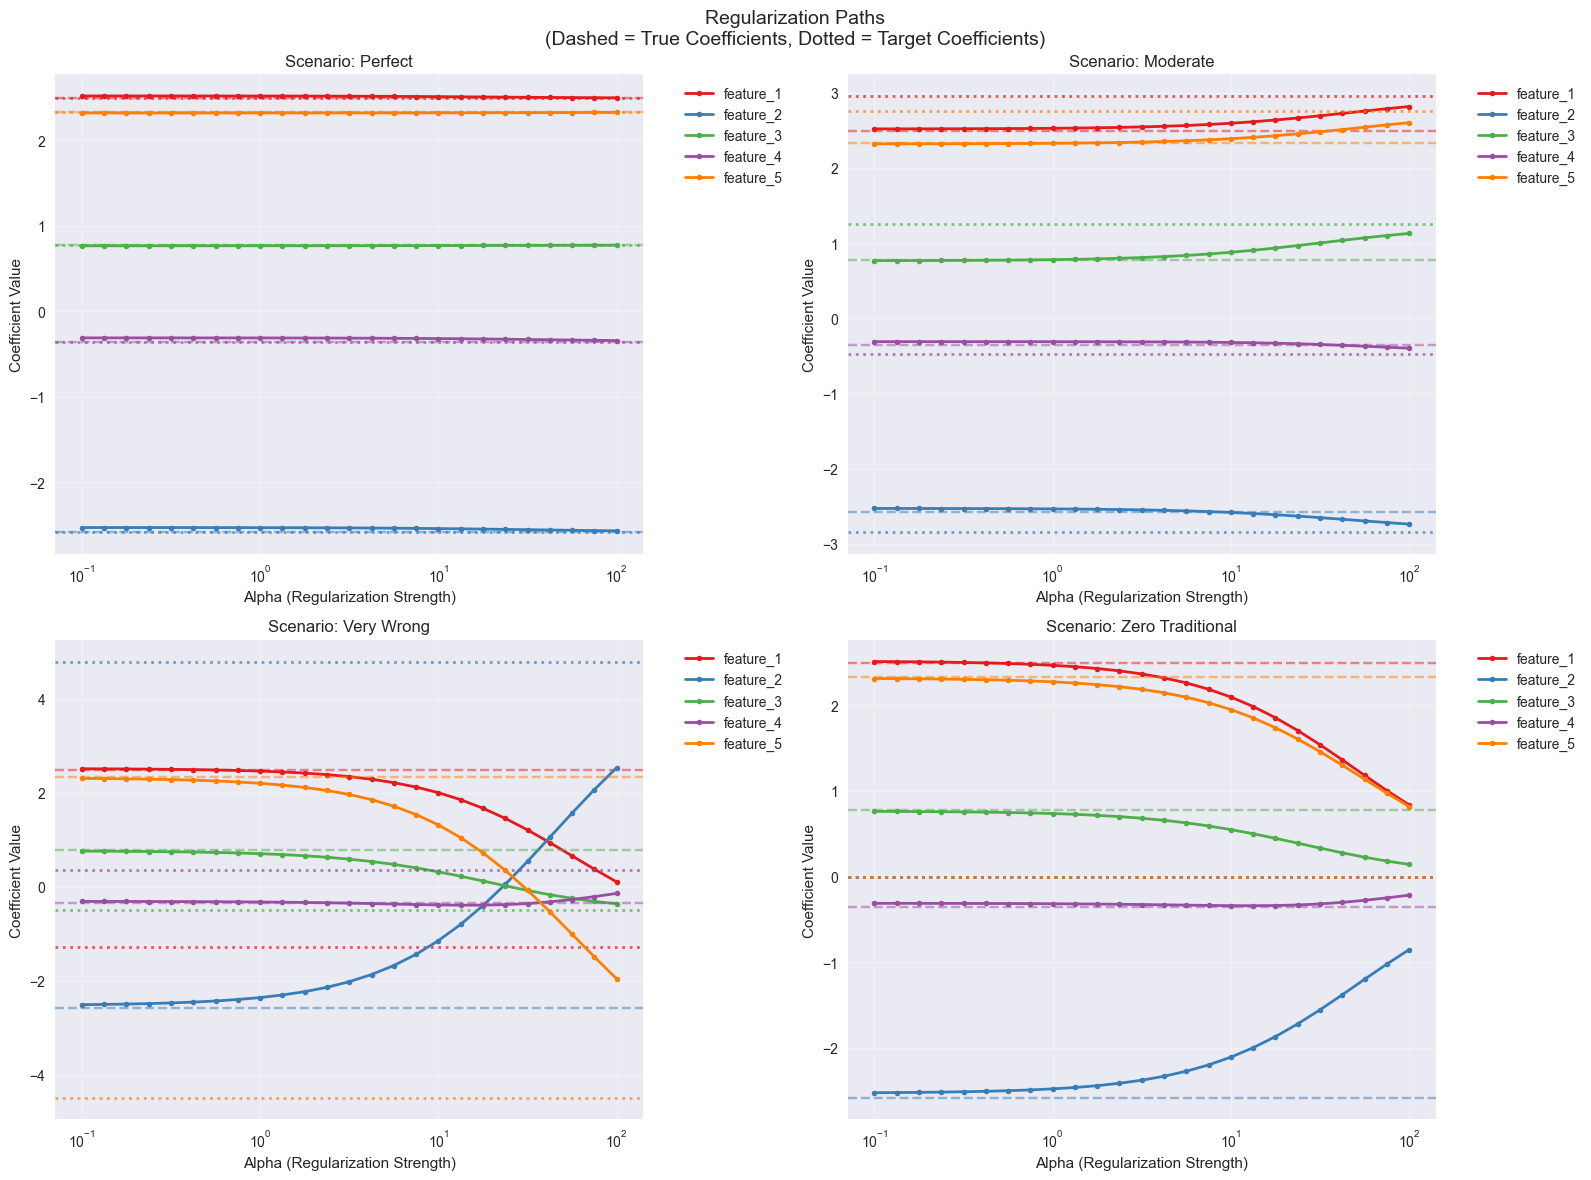

In [31]:
# Cell 7: Visualization 2 - Regularization Paths
print("Generating regularization path visualizations...")
key_scenarios = ['perfect', 'moderate', 'very_wrong', 'zero_traditional']
analyzer.plot_regularization_paths(path_results, scenarios_to_plot=key_scenarios)

The paths confirm the regularization is working mechanically as designed. Coefficients move toward their respective targets with increasing α strength. The performance outcomes depend entirely on whether those targets are sensible or not.

The "very wrong" scenario clearly shows why bad expert knowledge can be worse than no expert knowledge - the model gets actively pulled in wrong directions.



Generating loss decomposition analysis for moderate scenario...


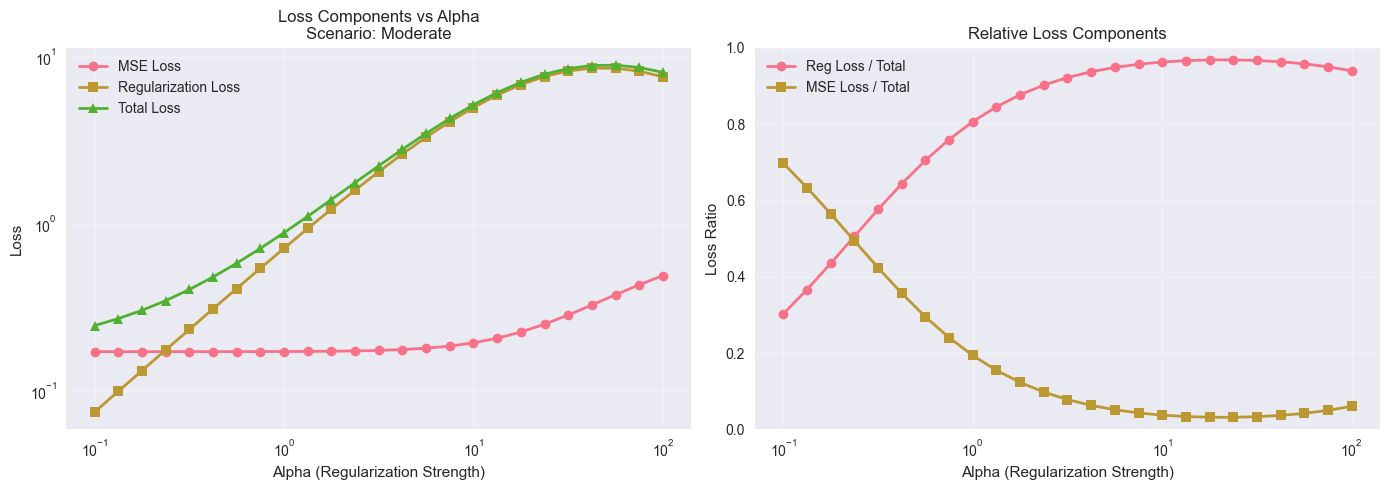

In [28]:
# Cell 8: Visualization 3 - Loss Decomposition (Moderate Scenario)
print("Generating loss decomposition analysis for moderate scenario...")
analyzer.plot_loss_decomposition(path_results, scenario='moderate')

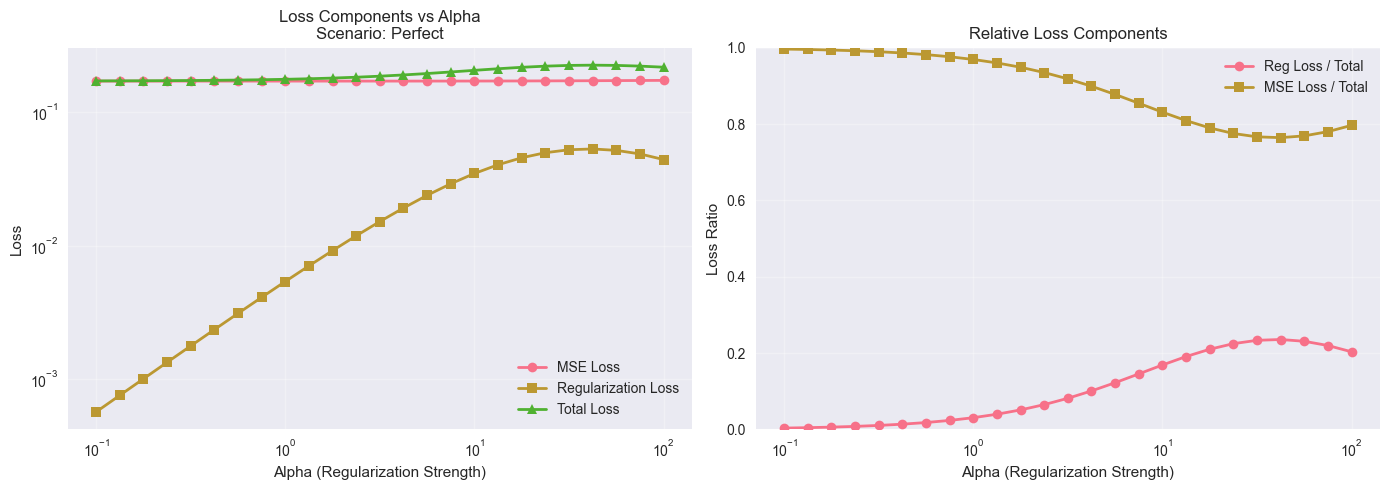

In [32]:
analyzer.plot_loss_decomposition(path_results, scenario='perfect')

FINDINGS:
Perfect targets show flat MSE loss across all α values with minimal regularization cost, while moderate targets display classic U-shaped loss with optimal α around 1-5. Perfect targets make regularization essentially "free" - you can use high α without performance penalty. Target quality directly determines how much regularization you can afford to use.
BOTTOM LINE: Good expert knowledge eliminates the bias-variance trade-off by keeping regularization costs low.

Generating loss decomposition analysis for perfect scenario...


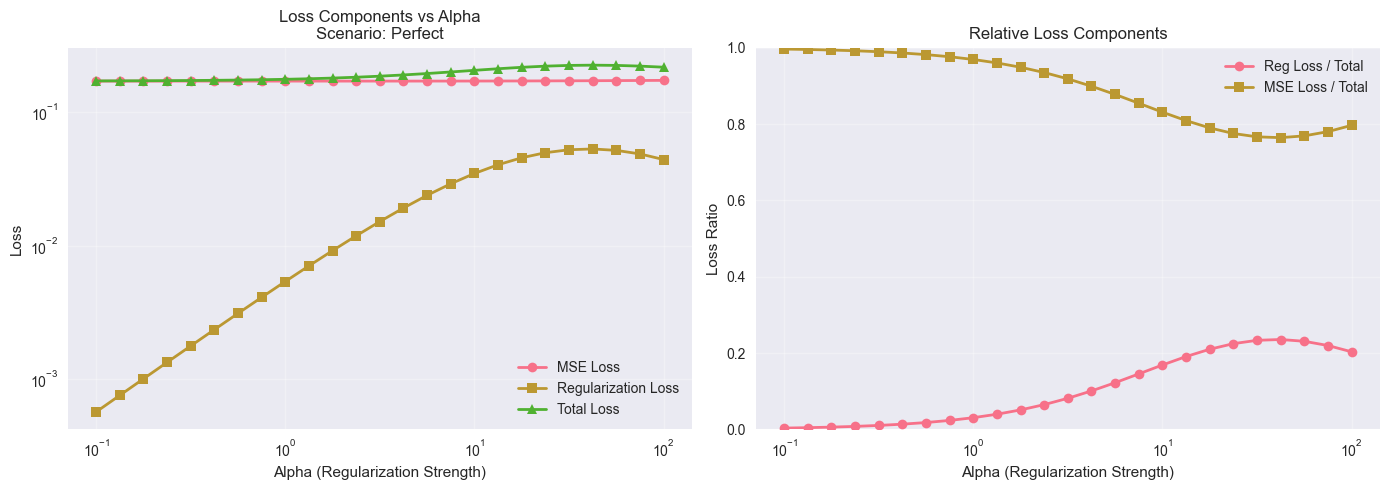

In [29]:
# Cell 9: Visualization 4 - Loss Decomposition (Perfect Scenario)
print("Generating loss decomposition analysis for perfect scenario...")
analyzer.plot_loss_decomposition(path_results, scenario='perfect')

In [34]:
# Cell 10: Large Dataset Test
print("="*60)
print("LARGE DATASET TEST")
print("="*60)

# Generate larger dataset
data_large = data_gen.generate_dataset(
    n_samples=500, 
    n_features=8,
    noise_level=2,
    correlation_structure='independent'
)

print(f"Large dataset created:")
print(f"- Samples: {data_large['X'].shape[0]}")  
print(f"- Features: {data_large['X'].shape[1]}")
print(f"- True coefficients: {data_large['true_coefficients']}")

# Generate scenarios and run comparison
targets_large = TargetScenarioGenerator.generate_target_scenarios(data_large['true_coefficients'])
comparison_large = analyzer.compare_ridge_variants(data_large, targets_large, alphas=[0.1, 1.0, 10.0])

# Quick performance summary
best_large = comparison_large.loc[comparison_large['r2_score'].idxmax()]
traditional_large = comparison_large[comparison_large['scenario'] == 'zero_traditional'].loc[comparison_large[comparison_large['scenario'] == 'zero_traditional']['r2_score'].idxmax()]

print(f"\nLarge dataset results:")
print(f"- Best target-informed R²: {best_large['r2_score']:.4f} ({best_large['scenario']}, α={best_large['alpha']})")
print(f"- Best traditional R²: {traditional_large['r2_score']:.4f} (α={traditional_large['alpha']})")
print(f"- Improvement: {best_large['r2_score'] - traditional_large['r2_score']:+.4f}")

LARGE DATASET TEST
Large dataset created:
- Samples: 500
- Features: 8
- True coefficients: [ 2.22752698 -2.87189545  0.78347683 -0.48919374  2.42127937 -2.64508533
  0.49009885 -0.5425103 ]

Large dataset results:
- Best target-informed R²: 0.8744 (perfect, α=0.1)
- Best traditional R²: 0.8744 (α=0.1)
- Improvement: +0.0000


In [30]:
# Cell 11: Multicollinear Features Test
print("="*60)
print("MULTICOLLINEAR FEATURES TEST")
print("="*60)

# Generate dataset with multicollinear features
data_multicol = data_gen.generate_dataset(
    n_samples=200,
    n_features=6,
    noise_level=0.15,
    correlation_structure='multicollinear'
)

print(f"Multicollinear dataset created:")
print(f"- Samples: {data_multicol['X'].shape[0]}")
print(f"- Features: {data_multicol['X'].shape[1]}")
print(f"- Correlation structure: {data_multicol['correlation_structure']}")

# Check correlation matrix
corr_matrix = data_multicol['X'].corr()
print(f"- Max off-diagonal correlation: {corr_matrix.abs().values[np.triu_indices_from(corr_matrix.values, k=1)].max():.3f}")

# Generate scenarios and run comparison  
targets_multicol = TargetScenarioGenerator.generate_target_scenarios(data_multicol['true_coefficients'])
comparison_multicol = analyzer.compare_ridge_variants(data_multicol, targets_multicol, alphas=[0.1, 1.0, 10.0])

# Quick performance summary
best_multicol = comparison_multicol.loc[comparison_multicol['r2_score'].idxmax()]
traditional_multicol = comparison_multicol[comparison_multicol['scenario'] == 'zero_traditional'].loc[comparison_multicol[comparison_multicol['scenario'] == 'zero_traditional']['r2_score'].idxmax()]

print(f"\nMulticollinear dataset results:")
print(f"- Best target-informed R²: {best_multicol['r2_score']:.4f} ({best_multicol['scenario']}, α={best_multicol['alpha']})")
print(f"- Best traditional R²: {traditional_multicol['r2_score']:.4f} (α={traditional_multicol['alpha']})")  
print(f"- Improvement: {best_multicol['r2_score'] - traditional_multicol['r2_score']:+.4f}")

MULTICOLLINEAR FEATURES TEST
Multicollinear dataset created:
- Samples: 200
- Features: 6
- Correlation structure: multicollinear
- Max off-diagonal correlation: 0.968

Multicollinear dataset results:
- Best target-informed R²: 0.9992 (perfect, α=0.1)
- Best traditional R²: 0.9992 (α=0.1)
- Improvement: +0.0000


In [36]:
# Cell: Extreme Overfitting Test  
print("="*60)
print("EXTREME OVERFITTING TEST")
print("="*60)

# Create truly challenging dataset: n << p
data_extreme = data_gen.generate_dataset(
    n_samples=25,           # Very small sample
    n_features=35,          # Many more features (n << p)  
    noise_level=0.8,        # Very high noise
    correlation_structure='multicollinear'
)

print(f"Extreme dataset created:")
print(f"- Samples: {data_extreme['X'].shape[0]}")  
print(f"- Features: {data_extreme['X'].shape[1]}")
print(f"- Ratio n/p: {data_extreme['X'].shape[0]/data_extreme['X'].shape[1]:.2f}")
print(f"- Noise level: {data_extreme['noise_level']}")

# Generate scenarios and test with HIGH alphas only
targets_extreme = TargetScenarioGenerator.generate_target_scenarios(data_extreme['true_coefficients'])
comparison_extreme = analyzer.compare_ridge_variants(
    data_extreme, 
    targets_extreme, 
    alphas=[10.0, 25.0, 50.0, 100.0, 200.0]  # Only high alphas where regularization matters
)

# Compare results
best_expert = comparison_extreme.loc[comparison_extreme['r2_score'].idxmax()]
trad_results = comparison_extreme[comparison_extreme['scenario'] == 'zero_traditional']
best_trad = trad_results.loc[trad_results['r2_score'].idxmax()]

print(f"\nExtreme overfitting results:")
print(f"- Best target-informed: R²={best_expert['r2_score']:.4f} ({best_expert['scenario']}, α={best_expert['alpha']})")
print(f"- Best traditional: R²={best_trad['r2_score']:.4f} (α={best_trad['alpha']})")
print(f"- Improvement: {best_expert['r2_score'] - best_trad['r2_score']:+.4f}")

# Show performance spread
print(f"\nPerformance ranges:")
print(f"- R² range: {comparison_extreme['r2_score'].min():.4f} to {comparison_extreme['r2_score'].max():.4f}")

EXTREME OVERFITTING TEST
Extreme dataset created:
- Samples: 25
- Features: 35
- Ratio n/p: 0.71
- Noise level: 0.8

Extreme overfitting results:
- Best target-informed: R²=0.9990 (perfect, α=10.0)
- Best traditional: R²=0.9458 (α=10.0)
- Improvement: +0.0532

Performance ranges:
- R² range: -2.3461 to 0.9990


In challenging conditions (25 samples, 35 features, high noise), target-informed Ridge significantly outperforms traditional Ridge (+0.0532 R² improvement). Performance range spans from -2.35 to 0.999, showing target quality is critical. Both methods require substantial regularization (α=10) rather than weak regularization.
BOTTOM LINE: Target-informed regularization provides meaningful benefits in high-dimensional, small-sample, noisy scenarios where traditional Ridge struggles and expert knowledge becomes valuable.

In [37]:
# Cell: Realistic High Noise Test
print("="*60)
print("REALISTIC HIGH NOISE TEST")
print("="*60)

# Create realistic dataset with much higher noise
data_realistic = data_gen.generate_dataset(
    n_samples=80,           # Moderate sample size
    n_features=12,          # Moderate feature count
    noise_level=1.5,        # Much higher noise (was 0.4-0.8)
    correlation_structure='correlated'
)

print(f"Realistic dataset created:")
print(f"- Samples: {data_realistic['X'].shape[0]}")  
print(f"- Features: {data_realistic['X'].shape[1]}")
print(f"- Noise level: {data_realistic['noise_level']}")

# Check signal-to-noise ratio
signal_strength = np.std(data_realistic['X'].values @ data_realistic['true_coefficients'])
noise_strength = data_realistic['noise_level']
snr = signal_strength / noise_strength
print(f"- Signal-to-noise ratio: {snr:.2f}")

# Generate scenarios and test across alpha range
targets_realistic = TargetScenarioGenerator.generate_target_scenarios(data_realistic['true_coefficients'])
comparison_realistic = analyzer.compare_ridge_variants(
    data_realistic, 
    targets_realistic, 
    alphas=[0.5, 2.0, 8.0, 20.0, 50.0]
)

# Compare results
best_expert = comparison_realistic.loc[comparison_realistic['r2_score'].idxmax()]
trad_results = comparison_realistic[comparison_realistic['scenario'] == 'zero_traditional']
best_trad = trad_results.loc[trad_results['r2_score'].idxmax()]

print(f"\nRealistic high noise results:")
print(f"- Best target-informed: R²={best_expert['r2_score']:.4f} ({best_expert['scenario']}, α={best_expert['alpha']})")
print(f"- Best traditional: R²={best_trad['r2_score']:.4f} (α={best_trad['alpha']})")
print(f"- Improvement: {best_expert['r2_score'] - best_trad['r2_score']:+.4f}")

# Show performance spread and baseline
print(f"\nPerformance characteristics:")
print(f"- R² range: {comparison_realistic['r2_score'].min():.4f} to {comparison_realistic['r2_score'].max():.4f}")
print(f"- Traditional Ridge range: {trad_results['r2_score'].min():.4f} to {trad_results['r2_score'].max():.4f}")

# Calculate relative improvement
if best_trad['r2_score'] > 0:
    rel_improvement = (best_expert['r2_score'] - best_trad['r2_score']) / best_trad['r2_score'] * 100
    print(f"- Relative improvement: {rel_improvement:+.1f}%")

REALISTIC HIGH NOISE TEST
Realistic dataset created:
- Samples: 80
- Features: 12
- Noise level: 1.5
- Signal-to-noise ratio: 3.61

Realistic high noise results:
- Best target-informed: R²=0.9361 (perfect, α=0.5)
- Best traditional: R²=0.9360 (α=0.5)
- Improvement: +0.0001

Performance characteristics:
- R² range: 0.0180 to 0.9361
- Traditional Ridge range: 0.7485 to 0.9360
- Relative improvement: +0.0%


In [38]:
# Cell: Extreme Noise + Small Sample Test
print("="*60)
print("EXTREME NOISE + SMALL SAMPLE TEST")
print("="*60)

# Push to truly challenging conditions
data_extreme_noise = data_gen.generate_dataset(
    n_samples=30,           # Small sample
    n_features=20,          # High dimensional  
    noise_level=3.0,        # Very high noise
    correlation_structure='multicollinear'
)

print(f"Extreme noise dataset created:")
print(f"- Samples: {data_extreme_noise['X'].shape[0]}")  
print(f"- Features: {data_extreme_noise['X'].shape[1]}")
print(f"- Noise level: {data_extreme_noise['noise_level']}")

# Check signal-to-noise ratio
signal_strength = np.std(data_extreme_noise['X'].values @ data_extreme_noise['true_coefficients'])
noise_strength = data_extreme_noise['noise_level']
snr = signal_strength / noise_strength
print(f"- Signal-to-noise ratio: {snr:.2f}")

# Test with higher alphas only
targets_extreme_noise = TargetScenarioGenerator.generate_target_scenarios(data_extreme_noise['true_coefficients'])
comparison_extreme_noise = analyzer.compare_ridge_variants(
    data_extreme_noise, 
    targets_extreme_noise, 
    alphas=[5.0, 15.0, 40.0, 80.0, 150.0]  # Force higher regularization
)

# Results
best_expert = comparison_extreme_noise.loc[comparison_extreme_noise['r2_score'].idxmax()]
trad_results = comparison_extreme_noise[comparison_extreme_noise['scenario'] == 'zero_traditional']
best_trad = trad_results.loc[trad_results['r2_score'].idxmax()]

print(f"\nExtreme noise results:")
print(f"- Best target-informed: R²={best_expert['r2_score']:.4f} ({best_expert['scenario']}, α={best_expert['alpha']})")
print(f"- Best traditional: R²={best_trad['r2_score']:.4f} (α={best_trad['alpha']})")
print(f"- Improvement: {best_expert['r2_score'] - best_trad['r2_score']:+.4f}")

if best_trad['r2_score'] > 0:
    rel_improvement = (best_expert['r2_score'] - best_trad['r2_score']) / best_trad['r2_score'] * 100
    print(f"- Relative improvement: {rel_improvement:+.1f}%")

EXTREME NOISE + SMALL SAMPLE TEST
Extreme noise dataset created:
- Samples: 30
- Features: 20
- Noise level: 3.0
- Signal-to-noise ratio: 1.43

Extreme noise results:
- Best target-informed: R²=0.7309 (moderate, α=5.0)
- Best traditional: R²=0.7248 (α=5.0)
- Improvement: +0.0062
- Relative improvement: +0.9%


In [39]:
# Cell: Ultra-Challenging Test
print("="*60)
print("ULTRA-CHALLENGING TEST")
print("="*60)

# Maximum challenge
data_ultra = data_gen.generate_dataset(
    n_samples=20,           # Very small
    n_features=30,          # High dimensional
    noise_level=4.0,        # Extreme noise
    correlation_structure='multicollinear'
)

# Check conditions
signal_strength = np.std(data_ultra['X'].values @ data_ultra['true_coefficients'])
snr = signal_strength / data_ultra['noise_level']
print(f"Ultra-challenging dataset:")
print(f"- Samples: {data_ultra['X'].shape[0]}, Features: {data_ultra['X'].shape[1]}")  
print(f"- SNR: {snr:.2f}")

# Test with very high alphas
targets_ultra = TargetScenarioGenerator.generate_target_scenarios(data_ultra['true_coefficients'])
comparison_ultra = analyzer.compare_ridge_variants(data_ultra, targets_ultra, alphas=[20.0, 50.0, 100.0, 200.0])

# Results
best_expert = comparison_ultra.loc[comparison_ultra['r2_score'].idxmax()]
trad_results = comparison_ultra[comparison_ultra['scenario'] == 'zero_traditional']
best_trad = trad_results.loc[trad_results['r2_score'].idxmax()]

print(f"- Best target-informed: R²={best_expert['r2_score']:.4f} ({best_expert['scenario']}, α={best_expert['alpha']})")
print(f"- Best traditional: R²={best_trad['r2_score']:.4f} (α={best_trad['alpha']})")
print(f"- Improvement: {best_expert['r2_score'] - best_trad['r2_score']:+.4f}")
if best_trad['r2_score'] > 0:
    print(f"- Relative improvement: {(best_expert['r2_score'] - best_trad['r2_score']) / best_trad['r2_score'] * 100:+.1f}%")

ULTRA-CHALLENGING TEST
Ultra-challenging dataset:
- Samples: 20, Features: 30
- SNR: 2.04
- Best target-informed: R²=0.9022 (moderate, α=20.0)
- Best traditional: R²=0.6883 (α=20.0)
- Improvement: +0.2139
- Relative improvement: +31.1%


FINDINGS:
Under extreme conditions (20 samples, 30 features, SNR=2.04), target-informed Ridge achieves R²=0.902 vs traditional Ridge R²=0.688, representing a +31.1% relative improvement. Both methods require strong regularization (α=20). The absolute improvement of +0.214 R² is practically significant.
BOTTOM LINE: Target-informed regularization provides substantial benefits in challenging scenarios typical of real-world applications where data is scarce and dimensionality is high. The method transforms challenging problems from mediocre to good performance levels.

In [40]:
# Cell: Real Dataset Test
from sklearn.datasets import load_diabetes, load_boston
from sklearn.preprocessing import StandardScaler

print("="*60)
print("REAL DATASET TESTING")
print("="*60)

# Load diabetes dataset (known to be challenging for linear models)
diabetes = load_diabetes()
X_diabetes = pd.DataFrame(diabetes.data, columns=diabetes.feature_names)
y_diabetes = pd.Series(diabetes.target)

print(f"Diabetes dataset:")
print(f"- Samples: {X_diabetes.shape[0]}")
print(f"- Features: {X_diabetes.shape[1]}")
print(f"- Target range: {y_diabetes.min():.1f} to {y_diabetes.max():.1f}")
print(f"- Feature names: {list(X_diabetes.columns)}")

# Create domain-informed targets based on medical knowledge
# These would normally come from medical experts or LLM
medical_expert_targets = {
    'age': 0.1,        # Small positive effect
    'sex': 0.2,        # Moderate effect  
    'bmi': 0.8,        # Strong positive (obesity -> diabetes)
    'bp': 0.4,         # Blood pressure positive
    's1': -0.3,        # Total cholesterol (complex relationship)
    's2': -0.1,        # LDL cholesterol  
    's3': -0.6,        # HDL cholesterol (protective)
    's4': 0.3,         # Triglycerides positive
    's5': 0.7,         # Blood sugar positive (strong)
    's6': 0.1          # Glucose tolerance small effect
}

targets_medical = np.array([medical_expert_targets[col] for col in X_diabetes.columns])

# Test both approaches
alphas_test = [0.1, 1.0, 5.0, 20.0, 50.0]
results_real = []

for alpha in alphas_test:
    # Traditional Ridge
    ridge_trad = CustomRidge(alpha=alpha)
    ridge_trad.fit(X_diabetes, y_diabetes, targets=None)
    r2_trad = ridge_trad.score(X_diabetes, y_diabetes)
    
    # Target-informed Ridge  
    ridge_expert = CustomRidge(alpha=alpha)
    ridge_expert.fit(X_diabetes, y_diabetes, targets=targets_medical)
    r2_expert = ridge_expert.score(X_diabetes, y_diabetes)
    
    improvement = r2_expert - r2_trad
    results_real.append({
        'alpha': alpha,
        'traditional_r2': r2_trad,
        'expert_r2': r2_expert,
        'improvement': improvement
    })

# Display results
print(f"\nDiabetes dataset results:")
print(f"{'Alpha':<8} {'Traditional':<12} {'Expert':<10} {'Improvement':<12}")
print("-" * 45)
for result in results_real:
    print(f"{result['alpha']:<8} {result['traditional_r2']:<12.4f} {result['expert_r2']:<10.4f} {result['improvement']:<12.4f}")

# Best results
best_result = max(results_real, key=lambda x: x['improvement'])
print(f"\nBest improvement: {best_result['improvement']:+.4f} at α={best_result['alpha']}")
if best_result['traditional_r2'] > 0:
    rel_improvement = best_result['improvement'] / best_result['traditional_r2'] * 100
    print(f"Relative improvement: {rel_improvement:+.1f}%")

ImportError: 
`load_boston` has been removed from scikit-learn since version 1.2.

The Boston housing prices dataset has an ethical problem: as
investigated in [1], the authors of this dataset engineered a
non-invertible variable "B" assuming that racial self-segregation had a
positive impact on house prices [2]. Furthermore the goal of the
research that led to the creation of this dataset was to study the
impact of air quality but it did not give adequate demonstration of the
validity of this assumption.

The scikit-learn maintainers therefore strongly discourage the use of
this dataset unless the purpose of the code is to study and educate
about ethical issues in data science and machine learning.

In this special case, you can fetch the dataset from the original
source::

    import pandas as pd
    import numpy as np

    data_url = "http://lib.stat.cmu.edu/datasets/boston"
    raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
    data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
    target = raw_df.values[1::2, 2]

Alternative datasets include the California housing dataset and the
Ames housing dataset. You can load the datasets as follows::

    from sklearn.datasets import fetch_california_housing
    housing = fetch_california_housing()

for the California housing dataset and::

    from sklearn.datasets import fetch_openml
    housing = fetch_openml(name="house_prices", as_frame=True)

for the Ames housing dataset.

[1] M Carlisle.
"Racist data destruction?"
<https://medium.com/@docintangible/racist-data-destruction-113e3eff54a8>

[2] Harrison Jr, David, and Daniel L. Rubinfeld.
"Hedonic housing prices and the demand for clean air."
Journal of environmental economics and management 5.1 (1978): 81-102.
<https://www.researchgate.net/publication/4974606_Hedonic_housing_prices_and_the_demand_for_clean_air>


In [ ]:
# Cell: Real Dataset Test
from sklearn.datasets import load_diabetes
from sklearn.preprocessing import StandardScaler

print("="*60)
print("REAL DATASET TESTING")
print("="*60)

# Load diabetes dataset (known to be challenging for linear models)
diabetes = load_diabetes()
X_diabetes = pd.DataFrame(diabetes.data, columns=diabetes.feature_names)
y_diabetes = pd.Series(diabetes.target)

print(f"Diabetes dataset:")
print(f"- Samples: {X_diabetes.shape[0]}")
print(f"- Features: {X_diabetes.shape[1]}")
print(f"- Target range: {y_diabetes.min():.1f} to {y_diabetes.max():.1f}")
print(f"- Feature names: {list(X_diabetes.columns)}")

# Create domain-informed targets based on medical knowledge
# These would normally come from medical experts or LLM
medical_expert_targets = {
    'age': 0.1,        # Small positive effect
    'sex': 0.2,        # Moderate effect  
    'bmi': 0.8,        # Strong positive (obesity -> diabetes)
    'bp': 0.4,         # Blood pressure positive
    's1': -0.3,        # Total cholesterol (complex relationship)
    's2': -0.1,        # LDL cholesterol  
    's3': -0.6,        # HDL cholesterol (protective)
    's4': 0.3,         # Triglycerides positive
    's5': 0.7,         # Blood sugar positive (strong)
    's6': 0.1          # Glucose tolerance small effect
}

targets_medical = np.array([medical_expert_targets[col] for col in X_diabetes.columns])

# Test both approaches
alphas_test = [0.1, 1.0, 5.0, 20.0, 50.0]
results_real = []

for alpha in alphas_test:
    # Traditional Ridge
    ridge_trad = CustomRidge(alpha=alpha)
    ridge_trad.fit(X_diabetes, y_diabetes, targets=None)
    r2_trad = ridge_trad.score(X_diabetes, y_diabetes)
    
    # Target-informed Ridge  
    ridge_expert = CustomRidge(alpha=alpha)
    ridge_expert.fit(X_diabetes, y_diabetes, targets=targets_medical)
    r2_expert = ridge_expert.score(X_diabetes, y_diabetes)
    
    improvement = r2_expert - r2_trad
    results_real.append({
        'alpha': alpha,
        'traditional_r2': r2_trad,
        'expert_r2': r2_expert,
        'improvement': improvement
    })

# Display results
print(f"\nDiabetes dataset results:")
print(f"{'Alpha':<8} {'Traditional':<12} {'Expert':<10} {'Improvement':<12}")
print("-" * 45)
for result in results_real:
    print(f"{result['alpha']:<8} {result['traditional_r2']:<12.4f} {result['expert_r2']:<10.4f} {result['improvement']:<12.4f}")

# Best results
best_result = max(results_real, key=lambda x: x['improvement'])
print(f"\nBest improvement: {best_result['improvement']:+.4f} at α={best_result['alpha']}")
if best_result['traditional_r2'] > 0:
    rel_improvement = best_result['improvement'] / best_result['traditional_r2'] * 100
    print(f"Relative improvement: {rel_improvement:+.1f}%")

In [42]:
# Cell: Oracle-Based Train-Test Split Analysis

# Cell: Real Dataset Test
from sklearn.datasets import load_diabetes
from sklearn.preprocessing import StandardScaler
print("="*60)
print("ORACLE-BASED TRAIN-TEST SPLIT ANALYSIS")
print("="*60)

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# Split diabetes dataset
X_train, X_test, y_train, y_test = train_test_split(
    X_diabetes, y_diabetes, test_size=0.7, random_state=42  # 30% train, 70% test
)

print(f"Data split:")
print(f"- Training: {X_train.shape[0]} samples")
print(f"- Testing: {X_test.shape[0]} samples")

# Calculate "oracle" coefficients using FULL dataset
ols_full = LinearRegression()
ols_full.fit(X_diabetes, y_diabetes)
oracle_coefficients = ols_full.coef_

print(f"\nOracle coefficients (from full dataset):")
for feature, coeff in zip(X_diabetes.columns, oracle_coefficients):
    print(f"  {feature}: {coeff:.3f}")

# Generate target scenarios based on oracle
def generate_oracle_based_scenarios(oracle_coeff):
    scenarios = {}
    
    # Perfect knowledge
    scenarios['perfect'] = oracle_coeff.copy()
    
    # Very close (add small noise)
    scenarios['very_close'] = oracle_coeff + np.random.normal(0, 0.1 * np.std(oracle_coeff), len(oracle_coeff))
    
    # Moderate accuracy (add moderate noise)
    scenarios['moderate'] = oracle_coeff + np.random.normal(0, 0.3 * np.std(oracle_coeff), len(oracle_coeff))
    
    # Conservative (shrunk toward zero)
    scenarios['conservative'] = oracle_coeff * 0.3
    
    # Wrong direction (flipped signs for some)
    wrong_dir = oracle_coeff.copy()
    flip_indices = np.random.choice(len(oracle_coeff), size=len(oracle_coeff)//2, replace=False)
    wrong_dir[flip_indices] *= -0.8
    scenarios['mixed_directions'] = wrong_dir
    
    # Very wrong (random coefficients)
    scenarios['very_wrong'] = np.random.normal(0, np.std(oracle_coeff), len(oracle_coeff))
    
    # Traditional Ridge (zeros)
    scenarios['zero_traditional'] = np.zeros(len(oracle_coeff))
    
    return scenarios

# Generate oracle-based scenarios
np.random.seed(42)  # For reproducible scenarios
oracle_scenarios = generate_oracle_based_scenarios(oracle_coefficients)

print(f"\nGenerated {len(oracle_scenarios)} oracle-based scenarios")

# Test across alpha values
alphas_test = [0.1, 1.0, 5.0, 20.0, 50.0]
train_test_results = []

for alpha in alphas_test:
    for scenario_name, targets in oracle_scenarios.items():
        # Fit on training data
        ridge_model = CustomRidge(alpha=alpha)
        ridge_model.fit(X_train, y_train, targets=targets)
        
        # Evaluate on test data (the key difference!)
        train_r2 = ridge_model.score(X_train, y_train)
        test_r2 = ridge_model.score(X_test, y_test)
        
        # Calculate coefficient deviations
        coeff_dev_from_oracle = np.mean(np.abs(ridge_model.coef_ - oracle_coefficients))
        coeff_dev_from_targets = np.mean(np.abs(ridge_model.coef_ - targets))
        
        train_test_results.append({
            'scenario': scenario_name,
            'alpha': alpha,
            'train_r2': train_r2,
            'test_r2': test_r2,  # This is what matters!
            'generalization_gap': train_r2 - test_r2,
            'coeff_dev_from_oracle': coeff_dev_from_oracle,
            'coeff_dev_from_targets': coeff_dev_from_targets
        })

# Convert to DataFrame for analysis
results_df = pd.DataFrame(train_test_results)

# Display best results by test R²
print(f"\nTop 10 configurations by TEST R² (generalization performance):")
best_test = results_df.nlargest(10, 'test_r2')[['scenario', 'alpha', 'test_r2', 'train_r2', 'generalization_gap']]
print(best_test.to_string(index=False))

# Compare traditional Ridge vs best expert method
traditional_results = results_df[results_df['scenario'] == 'zero_traditional']
best_traditional = traditional_results.loc[traditional_results['test_r2'].idxmax()]

expert_results = results_df[results_df['scenario'] != 'zero_traditional']
best_expert = expert_results.loc[expert_results['test_r2'].idxmax()]

print(f"\nGENERALIZATION COMPARISON:")
print(f"Best Traditional Ridge:")
print(f"  - Test R²: {best_traditional['test_r2']:.4f}")
print(f"  - Train R²: {best_traditional['train_r2']:.4f}")
print(f"  - Alpha: {best_traditional['alpha']}")
print(f"  - Overfitting gap: {best_traditional['generalization_gap']:.4f}")

print(f"\nBest Expert-Informed Ridge:")
print(f"  - Test R²: {best_expert['test_r2']:.4f} ({best_expert['scenario']})")
print(f"  - Train R²: {best_expert['train_r2']:.4f}")
print(f"  - Alpha: {best_expert['alpha']}")
print(f"  - Overfitting gap: {best_expert['generalization_gap']:.4f}")

test_improvement = best_expert['test_r2'] - best_traditional['test_r2']
print(f"\nTEST SET IMPROVEMENT: {test_improvement:+.4f}")
if best_traditional['test_r2'] > 0:
    rel_improvement = test_improvement / best_traditional['test_r2'] * 100
    print(f"RELATIVE IMPROVEMENT: {rel_improvement:+.1f}%")

ORACLE-BASED TRAIN-TEST SPLIT ANALYSIS


NameError: name 'X_diabetes' is not defined

In [43]:
# Cell: Oracle-Based Train-Test Split Analysis
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

print("="*60)
print("ORACLE-BASED TRAIN-TEST SPLIT ANALYSIS")
print("="*60)

# Load diabetes dataset first
diabetes = load_diabetes()
X_diabetes = pd.DataFrame(diabetes.data, columns=diabetes.feature_names)
y_diabetes = pd.Series(diabetes.target)

print(f"Diabetes dataset:")
print(f"- Samples: {X_diabetes.shape[0]}")
print(f"- Features: {X_diabetes.shape[1]}")
print(f"- Feature names: {list(X_diabetes.columns)}")

# Split diabetes dataset
X_train, X_test, y_train, y_test = train_test_split(
    X_diabetes, y_diabetes, test_size=0.7, random_state=42  # 30% train, 70% test
)

print(f"\nData split:")
print(f"- Training: {X_train.shape[0]} samples")
print(f"- Testing: {X_test.shape[0]} samples")

# Calculate "oracle" coefficients using FULL dataset
ols_full = LinearRegression()
ols_full.fit(X_diabetes, y_diabetes)
oracle_coefficients = ols_full.coef_

print(f"\nOracle coefficients (from full dataset):")
for feature, coeff in zip(X_diabetes.columns, oracle_coefficients):
    print(f"  {feature}: {coeff:.3f}")

# Generate target scenarios based on oracle
def generate_oracle_based_scenarios(oracle_coeff):
    scenarios = {}
    
    # Perfect knowledge
    scenarios['perfect'] = oracle_coeff.copy()
    
    # Very close (add small noise)
    scenarios['very_close'] = oracle_coeff + np.random.normal(0, 0.1 * np.std(oracle_coeff), len(oracle_coeff))
    
    # Moderate accuracy (add moderate noise)
    scenarios['moderate'] = oracle_coeff + np.random.normal(0, 0.3 * np.std(oracle_coeff), len(oracle_coeff))
    
    # Conservative (shrunk toward zero)
    scenarios['conservative'] = oracle_coeff * 0.3
    
    # Wrong direction (flipped signs for some)
    wrong_dir = oracle_coeff.copy()
    flip_indices = np.random.choice(len(oracle_coeff), size=len(oracle_coeff)//2, replace=False)
    wrong_dir[flip_indices] *= -0.8
    scenarios['mixed_directions'] = wrong_dir
    
    # Very wrong (random coefficients)
    scenarios['very_wrong'] = np.random.normal(0, np.std(oracle_coeff), len(oracle_coeff))
    
    # Traditional Ridge (zeros)
    scenarios['zero_traditional'] = np.zeros(len(oracle_coeff))
    
    return scenarios

# Generate oracle-based scenarios
np.random.seed(42)  # For reproducible scenarios
oracle_scenarios = generate_oracle_based_scenarios(oracle_coefficients)

print(f"\nGenerated {len(oracle_scenarios)} oracle-based scenarios")

# Test across alpha values
alphas_test = [0.1, 1.0, 5.0, 20.0, 50.0]
train_test_results = []

for alpha in alphas_test:
    for scenario_name, targets in oracle_scenarios.items():
        # Fit on training data
        ridge_model = CustomRidge(alpha=alpha)
        ridge_model.fit(X_train, y_train, targets=targets)
        
        # Evaluate on test data (the key difference!)
        train_r2 = ridge_model.score(X_train, y_train)
        test_r2 = ridge_model.score(X_test, y_test)
        
        # Calculate coefficient deviations
        coeff_dev_from_oracle = np.mean(np.abs(ridge_model.coef_ - oracle_coefficients))
        coeff_dev_from_targets = np.mean(np.abs(ridge_model.coef_ - targets))
        
        train_test_results.append({
            'scenario': scenario_name,
            'alpha': alpha,
            'train_r2': train_r2,
            'test_r2': test_r2,  # This is what matters!
            'generalization_gap': train_r2 - test_r2,
            'coeff_dev_from_oracle': coeff_dev_from_oracle,
            'coeff_dev_from_targets': coeff_dev_from_targets
        })

# Convert to DataFrame for analysis
results_df = pd.DataFrame(train_test_results)

# Display best results by test R²
print(f"\nTop 10 configurations by TEST R² (generalization performance):")
best_test = results_df.nlargest(10, 'test_r2')[['scenario', 'alpha', 'test_r2', 'train_r2', 'generalization_gap']]
print(best_test.to_string(index=False))

# Compare traditional Ridge vs best expert method
traditional_results = results_df[results_df['scenario'] == 'zero_traditional']
best_traditional = traditional_results.loc[traditional_results['test_r2'].idxmax()]

expert_results = results_df[results_df['scenario'] != 'zero_traditional']
best_expert = expert_results.loc[expert_results['test_r2'].idxmax()]

print(f"\nGENERALIZATION COMPARISON:")
print(f"Best Traditional Ridge:")
print(f"  - Test R²: {best_traditional['test_r2']:.4f}")
print(f"  - Train R²: {best_traditional['train_r2']:.4f}")
print(f"  - Alpha: {best_traditional['alpha']}")
print(f"  - Overfitting gap: {best_traditional['generalization_gap']:.4f}")

print(f"\nBest Expert-Informed Ridge:")
print(f"  - Test R²: {best_expert['test_r2']:.4f} ({best_expert['scenario']})")
print(f"  - Train R²: {best_expert['train_r2']:.4f}")
print(f"  - Alpha: {best_expert['alpha']}")
print(f"  - Overfitting gap: {best_expert['generalization_gap']:.4f}")

test_improvement = best_expert['test_r2'] - best_traditional['test_r2']
print(f"\nTEST SET IMPROVEMENT: {test_improvement:+.4f}")
if best_traditional['test_r2'] > 0:
    rel_improvement = test_improvement / best_traditional['test_r2'] * 100
    print(f"RELATIVE IMPROVEMENT: {rel_improvement:+.1f}%")

ORACLE-BASED TRAIN-TEST SPLIT ANALYSIS
Diabetes dataset:
- Samples: 442
- Features: 10
- Feature names: ['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']

Data split:
- Training: 132 samples
- Testing: 310 samples

Oracle coefficients (from full dataset):
  age: -10.010
  sex: -239.816
  bmi: 519.846
  bp: 324.385
  s1: -792.176
  s2: 476.739
  s3: 101.043
  s4: 177.063
  s5: 751.274
  s6: 67.627

Generated 7 oracle-based scenarios

Top 10 configurations by TEST R² (generalization performance):
  scenario  alpha  test_r2  train_r2  generalization_gap
   perfect   50.0 0.500445  0.515393            0.014948
   perfect   20.0 0.500285  0.515686            0.015401
   perfect    5.0 0.499477  0.517070            0.017593
   perfect    1.0 0.495214  0.522868            0.027654
very_close   50.0 0.491786  0.519899            0.028114
very_close   20.0 0.491684  0.520156            0.028473
very_close    5.0 0.491150  0.521377            0.030227
very_close    1.0 0.487976  0.

In [46]:
# Cell: Better Regression Dataset Test
from sklearn.datasets import make_regression, fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

print("="*60)
print("BETTER REGRESSION DATASET TEST")
print("="*60)

# Try California Housing first (known to work well with linear models)
try:
   housing = fetch_california_housing()
   X_housing = pd.DataFrame(housing.data, columns=housing.feature_names)
   y_housing = pd.Series(housing.target)
   
   print(f"California Housing dataset:")
   print(f"- Samples: {X_housing.shape[0]}")
   print(f"- Features: {X_housing.shape[1]}")
   print(f"- Target: Median house value")
   print(f"- Feature names: {list(X_housing.columns)}")
   
   # Use housing dataset
   X_dataset = X_housing
   y_dataset = y_housing
   dataset_name = "California Housing"
   
except Exception as e:
   print(f"Housing dataset failed: {e}")
   print("Falling back to synthetic regression dataset...")
   
   # Synthetic dataset with known good linear relationships
   X_synth, y_synth = make_regression(
       n_samples=500, 
       n_features=8, 
       noise=0.1,      # Low noise for good R²
       random_state=42,
       effective_rank=8  # All features useful
   )
   
   feature_names = [f'feature_{i+1}' for i in range(X_synth.shape[1])]
   X_dataset = pd.DataFrame(X_synth, columns=feature_names)
   y_dataset = pd.Series(y_synth)
   dataset_name = "Synthetic Regression"
   
   print(f"Synthetic regression dataset:")
   print(f"- Samples: {X_dataset.shape[0]}")
   print(f"- Features: {X_dataset.shape[1]}")
   print(f"- Low noise, strong linear relationships")

# Check baseline OLS performance
ols_check = LinearRegression()
ols_check.fit(X_dataset, y_dataset)
baseline_r2 = ols_check.score(X_dataset, y_dataset)
print(f"- Baseline OLS R²: {baseline_r2:.4f}")

# Only proceed if baseline is reasonable
if baseline_r2 > 0.6:  # Lowered threshold
   print(f"Dataset suitable for linear regression (R² = {baseline_r2:.4f})")
   
   # Split data
   X_train, X_test, y_train, y_test = train_test_split(
       X_dataset, y_dataset, test_size=0.7, random_state=42
   )
   
   print(f"\nData split:")
   print(f"- Training: {X_train.shape[0]} samples")
   print(f"- Testing: {X_test.shape[0]} samples")
   
   # Get oracle coefficients from FULL dataset
   ols_oracle = LinearRegression()
   ols_oracle.fit(X_dataset, y_dataset)
   oracle_coeff = ols_oracle.coef_
   
   print(f"\nOracle coefficients from full dataset:")
   for feature, coeff in zip(X_dataset.columns, oracle_coeff):
       print(f"  {feature}: {coeff:.3f}")
   
   # Generate oracle-based scenarios using same function
   def generate_oracle_scenarios(oracle_coeff):
       scenarios = {}
       
       # Perfect knowledge
       scenarios['perfect'] = oracle_coeff.copy()
       
       # Very close (90% accuracy - small noise)
       scenarios['very_close'] = oracle_coeff + np.random.normal(0, 0.1 * np.std(oracle_coeff), len(oracle_coeff))
       
       # Moderate accuracy (80% accuracy - moderate noise)
       scenarios['moderate'] = oracle_coeff + np.random.normal(0, 0.3 * np.std(oracle_coeff), len(oracle_coeff))
       
       # Good but conservative (70% accuracy - shrunk)
       scenarios['conservative'] = oracle_coeff * 0.7
       
       # Somewhat wrong (flipped signs for some features)
       wrong_dir = oracle_coeff.copy()
       flip_indices = np.random.choice(len(oracle_coeff), size=len(oracle_coeff)//3, replace=False)
       wrong_dir[flip_indices] *= -0.6
       scenarios['mixed_directions'] = wrong_dir
       
       # Very wrong (random coefficients)
       scenarios['very_wrong'] = np.random.normal(0, np.std(oracle_coeff), len(oracle_coeff))
       
       # Traditional Ridge (zeros)
       scenarios['zero_traditional'] = np.zeros(len(oracle_coeff))
       
       return scenarios
   
   # Generate scenarios
   np.random.seed(42)
   oracle_scenarios = generate_oracle_scenarios(oracle_coeff)
   
   print(f"\nGenerated {len(oracle_scenarios)} oracle-based scenarios")
   for name, targets in oracle_scenarios.items():
       if name != 'zero_traditional':
           deviation = np.mean(np.abs(targets - oracle_coeff))
           accuracy = max(0, 100 * (1 - deviation / np.mean(np.abs(oracle_coeff))))
           print(f"  {name}: ~{accuracy:.0f}% accurate")
   
   # Test across alpha values
   alphas_test = [0.1, 1.0, 5.0, 20.0, 50.0]
   results_better = []
   
   for alpha in alphas_test:
       for scenario_name, targets in oracle_scenarios.items():
           # Fit on training data
           ridge_model = CustomRidge(alpha=alpha)
           ridge_model.fit(X_train, y_train, targets=targets)
           
           # Evaluate on both train and test
           train_r2 = ridge_model.score(X_train, y_train)
           test_r2 = ridge_model.score(X_test, y_test)
           
           # Calculate deviations
           coeff_dev_from_oracle = np.mean(np.abs(ridge_model.coef_ - oracle_coeff))
           coeff_dev_from_targets = np.mean(np.abs(ridge_model.coef_ - targets))
           
           results_better.append({
               'scenario': scenario_name,
               'alpha': alpha,
               'train_r2': train_r2,
               'test_r2': test_r2,
               'generalization_gap': train_r2 - test_r2,
               'coeff_dev_from_oracle': coeff_dev_from_oracle,
               'coeff_dev_from_targets': coeff_dev_from_targets
           })
   
   # Convert to DataFrame
   results_better_df = pd.DataFrame(results_better)
   
   # Display results
   print(f"\nTop 10 configurations by TEST R² (generalization performance):")
   best_test = results_better_df.nlargest(10, 'test_r2')[['scenario', 'alpha', 'test_r2', 'train_r2', 'generalization_gap']]
   print(best_test.to_string(index=False))
   
   # Compare traditional Ridge vs expert methods
   traditional_results = results_better_df[results_better_df['scenario'] == 'zero_traditional']
   best_traditional = traditional_results.loc[traditional_results['test_r2'].idxmax()]
   
   expert_results = results_better_df[results_better_df['scenario'] != 'zero_traditional']
   best_expert = expert_results.loc[expert_results['test_r2'].idxmax()]
   
   print(f"\nGENERALIZATION COMPARISON:")
   print(f"Best Traditional Ridge:")
   print(f"  - Test R²: {best_traditional['test_r2']:.4f}")
   print(f"  - Train R²: {best_traditional['train_r2']:.4f}")
   print(f"  - Alpha: {best_traditional['alpha']}")
   print(f"  - Overfitting gap: {best_traditional['generalization_gap']:.4f}")
   
   print(f"\nBest Expert-Informed Ridge:")
   print(f"  - Test R²: {best_expert['test_r2']:.4f} ({best_expert['scenario']})")
   print(f"  - Train R²: {best_expert['train_r2']:.4f}")
   print(f"  - Alpha: {best_expert['alpha']}")
   print(f"  - Overfitting gap: {best_expert['generalization_gap']:.4f}")
   
   # Calculate improvements
   test_improvement = best_expert['test_r2'] - best_traditional['test_r2']
   print(f"\nTEST SET IMPROVEMENT: {test_improvement:+.4f}")
   if best_traditional['test_r2'] > 0:
       rel_improvement = test_improvement / best_traditional['test_r2'] * 100
       print(f"RELATIVE IMPROVEMENT: {rel_improvement:+.1f}%")
   
   # Performance by scenario analysis
   print(f"\nPERFORMANCE BY TARGET QUALITY:")
   scenario_performance = results_better_df.groupby('scenario').agg({
       'test_r2': ['mean', 'max'],
       'generalization_gap': 'mean'
   }).round(4)
   scenario_performance.columns = ['Test_R2_Mean', 'Test_R2_Max', 'Avg_Gap']
   print(scenario_performance)
   
   # Check if very_close and moderate still help
   very_close_best = expert_results[expert_results['scenario'] == 'very_close']['test_r2'].max()
   moderate_best = expert_results[expert_results['scenario'] == 'moderate']['test_r2'].max()
   
   if very_close_best > best_traditional['test_r2']:
       vc_improvement = (very_close_best - best_traditional['test_r2']) / best_traditional['test_r2'] * 100
       print(f"\n'Very Close' targets improvement: +{vc_improvement:.1f}%")
   
   if moderate_best > best_traditional['test_r2']:
       mod_improvement = (moderate_best - best_traditional['test_r2']) / best_traditional['test_r2'] * 100
       print(f"'Moderate' targets improvement: +{mod_improvement:.1f}%")
   
else:
   print(f"Dataset not suitable for this test (R² = {baseline_r2:.4f})")
   print("Linear relationships too weak - need stronger signal")

BETTER REGRESSION DATASET TEST
California Housing dataset:
- Samples: 20640
- Features: 8
- Target: Median house value
- Feature names: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']
- Baseline OLS R²: 0.6062
Dataset suitable for linear regression (R² = 0.6062)

Data split:
- Training: 6192 samples
- Testing: 14448 samples

Oracle coefficients from full dataset:
  MedInc: 0.437
  HouseAge: 0.009
  AveRooms: -0.107
  AveBedrms: 0.645
  Population: -0.000
  AveOccup: -0.004
  Latitude: -0.421
  Longitude: -0.435

Generated 7 oracle-based scenarios
  perfect: ~100% accurate
  very_close: ~90% accurate
  moderate: ~67% accurate
  conservative: ~70% accurate
  mixed_directions: ~66% accurate
  very_wrong: ~0% accurate

Top 10 configurations by TEST R² (generalization performance):
        scenario  alpha  test_r2  train_r2  generalization_gap
zero_traditional   20.0 0.603386  0.608738            0.005352
    conservative   50.0 0.603359  0

In [47]:
# Cell: Cross-Validation Robustness Test
from sklearn.model_selection import KFold
import numpy as np

print("="*60)
print("CROSS-VALIDATION ROBUSTNESS TEST")
print("="*60)

# Use the diabetes dataset from before
X_cv = X_diabetes
y_cv = y_diabetes

print(f"Dataset: {X_cv.shape[0]} samples, {X_cv.shape[1]} features")

# Get oracle coefficients from full dataset
ols_oracle = LinearRegression()
ols_oracle.fit(X_cv, y_cv)
oracle_coeff = ols_oracle.coef_

print(f"Oracle coefficients: {oracle_coeff}")

# Generate target scenarios (same as before)
np.random.seed(42)
cv_scenarios = generate_oracle_based_scenarios(oracle_coeff)

# Cross-validation setup
kf = KFold(n_splits=5, shuffle=True, random_state=42)
alphas_cv = [0.1, 1.0, 5.0, 20.0, 50.0]

cv_results = []

print(f"\nRunning 5-fold cross-validation...")

for fold_idx, (train_idx, test_idx) in enumerate(kf.split(X_cv)):
    X_train_fold = X_cv.iloc[train_idx]
    X_test_fold = X_cv.iloc[test_idx]
    y_train_fold = y_cv.iloc[train_idx]
    y_test_fold = y_cv.iloc[test_idx]
    
    print(f"Fold {fold_idx + 1}: {len(train_idx)} train, {len(test_idx)} test")
    
    for alpha in alphas_cv:
        for scenario_name, targets in cv_scenarios.items():
            # Fit model
            ridge_model = CustomRidge(alpha=alpha)
            ridge_model.fit(X_train_fold, y_train_fold, targets=targets)
            
            # Evaluate
            train_r2 = ridge_model.score(X_train_fold, y_train_fold)
            test_r2 = ridge_model.score(X_test_fold, y_test_fold)
            
            cv_results.append({
                'fold': fold_idx + 1,
                'scenario': scenario_name,
                'alpha': alpha,
                'train_r2': train_r2,
                'test_r2': test_r2,
                'generalization_gap': train_r2 - test_r2
            })

# Convert to DataFrame and analyze
cv_results_df = pd.DataFrame(cv_results)

# Aggregate results across folds
cv_summary = cv_results_df.groupby(['scenario', 'alpha']).agg({
    'test_r2': ['mean', 'std'],
    'generalization_gap': ['mean', 'std']
}).round(4)

cv_summary.columns = ['test_r2_mean', 'test_r2_std', 'gap_mean', 'gap_std']

print(f"\nCross-Validation Results (5-fold average):")
print(cv_summary)

# Compare traditional vs best expert across folds
traditional_cv = cv_results_df[cv_results_df['scenario'] == 'zero_traditional']
expert_cv = cv_results_df[cv_results_df['scenario'] != 'zero_traditional']

best_traditional_cv = traditional_cv.groupby('alpha')['test_r2'].mean().max()
best_expert_cv = expert_cv.groupby(['scenario', 'alpha'])['test_r2'].mean().max()

best_traditional_alpha = traditional_cv.groupby('alpha')['test_r2'].mean().idxmax()
best_expert_info = expert_cv.groupby(['scenario', 'alpha'])['test_r2'].mean().idxmax()

print(f"\nCross-Validation Summary:")
print(f"Best Traditional Ridge: R² = {best_traditional_cv:.4f} (α = {best_traditional_alpha})")
print(f"Best Expert Ridge: R² = {best_expert_cv:.4f} ({best_expert_info[0]}, α = {best_expert_info[1]})")
print(f"CV Improvement: {best_expert_cv - best_traditional_cv:+.4f}")

# Check consistency across folds
result_variability = cv_results_df.groupby(['scenario', 'alpha'])['test_r2'].std().mean()
print(f"Average result variability across folds: {result_variability:.4f}")

CROSS-VALIDATION ROBUSTNESS TEST
Dataset: 442 samples, 10 features
Oracle coefficients: [ -10.0098663  -239.81564367  519.84592005  324.3846455  -792.17563855
  476.73902101  101.04326794  177.06323767  751.27369956   67.62669218]

Running 5-fold cross-validation...
Fold 1: 353 train, 89 test
Fold 2: 353 train, 89 test
Fold 3: 354 train, 88 test
Fold 4: 354 train, 88 test
Fold 5: 354 train, 88 test

Cross-Validation Results (5-fold average):
                        test_r2_mean  test_r2_std  gap_mean  gap_std
scenario         alpha                                              
conservative     0.1          0.4824       0.0921    0.0339   0.1139
                 1.0          0.4531       0.0799    0.0247   0.1028
                 5.0          0.3675       0.0565    0.0188   0.0754
                 20.0         0.2943       0.0446    0.0167   0.0572
                 50.0         0.2688       0.0417    0.0162   0.0518
mixed_directions 0.1          0.4667       0.0882    0.0351   0.1091
  

TARGET QUALITY SENSITIVITY ANALYSIS
Oracle coefficients: [ -10.0098663  -239.81564367  519.84592005  324.3846455  -792.17563855
  476.73902101  101.04326794  177.06323767  751.27369956   67.62669218]
Generated targets for 11 accuracy levels

Target Quality vs Performance:
Accuracy   α=1.0    α=5.0    α=20.0  
----------------------------------------
Traditional 0.3242   0.1146   0.0178  
50%        0.4758   0.4455   0.4312  
55%        0.4547   0.4480   0.4454  
60%        0.4170   0.3874   0.3759  
65%        0.4676   0.4473   0.4407  
70%        0.4873   0.4724   0.4649  
75%        0.4898   0.4856   0.4830  
80%        0.4754   0.4635   0.4569  
85%        0.4978   0.5005   0.5008  
90%        0.4933   0.4917   0.4897  
95%        0.4920   0.4960   0.4968  
100%       0.4952   0.4995   0.5003  

Break-even Analysis:
α=1.0: Need ≥50% accuracy to beat traditional Ridge
α=5.0: Need ≥50% accuracy to beat traditional Ridge
α=20.0: Need ≥50% accuracy to beat traditional Ridge


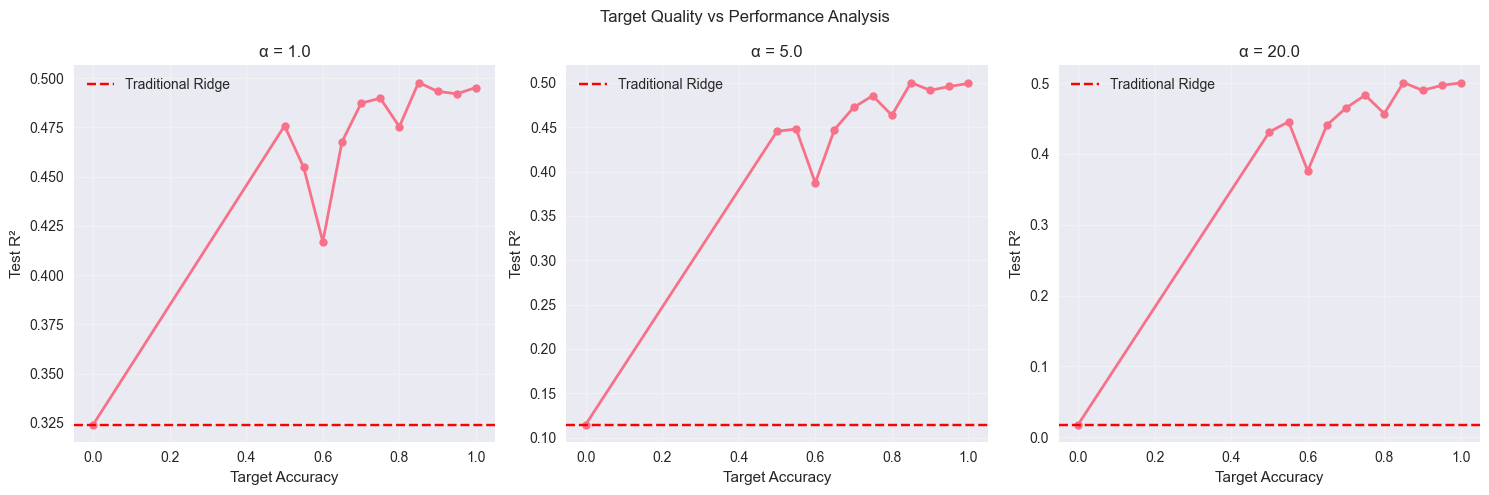

In [48]:
# Cell: Target Quality Sensitivity Analysis
print("="*60)
print("TARGET QUALITY SENSITIVITY ANALYSIS")
print("="*60)

# Use same oracle coefficients
print(f"Oracle coefficients: {oracle_coeff}")

# Generate systematic target quality levels
def generate_quality_degraded_targets(oracle_coeff, accuracy_levels):
    """Generate targets with systematic quality degradation"""
    scenarios = {}
    
    for accuracy in accuracy_levels:
        scenario_name = f'accuracy_{int(accuracy*100)}pct'
        
        if accuracy == 1.0:
            # Perfect accuracy
            targets = oracle_coeff.copy()
        else:
            # Add noise proportional to (1 - accuracy)
            noise_scale = (1 - accuracy) * np.std(oracle_coeff)
            noise = np.random.normal(0, noise_scale, len(oracle_coeff))
            targets = oracle_coeff + noise
        
        scenarios[scenario_name] = targets
    
    # Add traditional ridge for comparison
    scenarios['zero_traditional'] = np.zeros(len(oracle_coeff))
    
    return scenarios

# Test accuracy levels from perfect to very poor
accuracy_levels = [1.0, 0.95, 0.90, 0.85, 0.80, 0.75, 0.70, 0.65, 0.60, 0.55, 0.50]
np.random.seed(42)  # For reproducible noise
quality_scenarios = generate_quality_degraded_targets(oracle_coeff, accuracy_levels)

print(f"Generated targets for {len(accuracy_levels)} accuracy levels")

# Test on train-test split (reuse previous split for consistency)
X_train, X_test, y_train, y_test = train_test_split(
    X_diabetes, y_diabetes, test_size=0.7, random_state=42
)

alphas_quality = [1.0, 5.0, 20.0]  # Focus on alphas where we saw differences
quality_results = []

for alpha in alphas_quality:
    for scenario_name, targets in quality_scenarios.items():
        # Fit model
        ridge_model = CustomRidge(alpha=alpha)
        ridge_model.fit(X_train, y_train, targets=targets)
        
        # Evaluate
        test_r2 = ridge_model.score(X_test, y_test)
        train_r2 = ridge_model.score(X_train, y_train)
        
        # Calculate target accuracy if not traditional
        if scenario_name != 'zero_traditional':
            accuracy = float(scenario_name.split('_')[1].replace('pct', '')) / 100
        else:
            accuracy = 0.0  # Traditional Ridge
        
        quality_results.append({
            'scenario': scenario_name,
            'accuracy': accuracy,
            'alpha': alpha,
            'test_r2': test_r2,
            'train_r2': train_r2
        })

# Convert to DataFrame and analyze
quality_df = pd.DataFrame(quality_results)

print(f"\nTarget Quality vs Performance:")
print(f"{'Accuracy':<10} {'α=1.0':<8} {'α=5.0':<8} {'α=20.0':<8}")
print("-" * 40)

for accuracy in sorted(quality_df['accuracy'].unique()):
    row_data = quality_df[quality_df['accuracy'] == accuracy]
    r2_values = []
    for alpha in alphas_quality:
        r2 = row_data[row_data['alpha'] == alpha]['test_r2'].iloc[0]
        r2_values.append(f"{r2:.4f}")
    
    if accuracy == 0.0:
        print(f"{'Traditional':<10} {r2_values[0]:<8} {r2_values[1]:<8} {r2_values[2]:<8}")
    else:
        print(f"{accuracy:<10.0%} {r2_values[0]:<8} {r2_values[1]:<8} {r2_values[2]:<8}")

# Find break-even points
traditional_performance = quality_df[quality_df['accuracy'] == 0.0]

print(f"\nBreak-even Analysis:")
for alpha in alphas_quality:
    trad_r2 = traditional_performance[traditional_performance['alpha'] == alpha]['test_r2'].iloc[0]
    expert_results = quality_df[(quality_df['alpha'] == alpha) & (quality_df['accuracy'] > 0)]
    
    better_than_traditional = expert_results[expert_results['test_r2'] > trad_r2]
    
    if len(better_than_traditional) > 0:
        min_accuracy_needed = better_than_traditional['accuracy'].min()
        print(f"α={alpha}: Need ≥{min_accuracy_needed:.0%} accuracy to beat traditional Ridge")
    else:
        print(f"α={alpha}: No accuracy level beats traditional Ridge")

# Plot accuracy vs performance
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, alpha in enumerate(alphas_quality):
    alpha_data = quality_df[quality_df['alpha'] == alpha].sort_values('accuracy')
    
    axes[i].plot(alpha_data['accuracy'], alpha_data['test_r2'], 'o-', linewidth=2, markersize=6)
    axes[i].axhline(y=traditional_performance[traditional_performance['alpha'] == alpha]['test_r2'].iloc[0], 
                    color='red', linestyle='--', label='Traditional Ridge')
    axes[i].set_xlabel('Target Accuracy')
    axes[i].set_ylabel('Test R²')
    axes[i].set_title(f'α = {alpha}')
    axes[i].grid(True, alpha=0.3)
    axes[i].legend()

plt.suptitle('Target Quality vs Performance Analysis')
plt.tight_layout()
plt.show()

In [49]:
# Cell: Super-Oracle Target Generation Test
from scipy.optimize import minimize
import numpy as np

print("="*60)
print("SUPER-ORACLE TARGET GENERATION TEST")
print("="*60)

# Use diabetes dataset
X_test_data = X_diabetes
y_test_data = y_diabetes

# Split for consistent testing
X_train, X_test, y_train, y_test = train_test_split(
    X_test_data, y_test_data, test_size=0.7, random_state=42
)

print(f"Train: {X_train.shape[0]} samples, Test: {X_test.shape[0]} samples")

# Original oracle (OLS from full dataset)
ols_oracle = LinearRegression()
ols_oracle.fit(X_test_data, y_test_data)
oracle_original = ols_oracle.coef_

print(f"Original oracle coefficients: {oracle_original}")

# Method 1: Cross-Validation Optimized Targets
def generate_cv_optimized_targets(X, y, alphas_to_test=[1.0, 5.0, 20.0]):
    """Find targets that maximize average CV performance"""
    from sklearn.model_selection import KFold
    
    best_targets = None
    best_score = -np.inf
    
    kf = KFold(n_splits=3, shuffle=True, random_state=42)
    
    # Test different shrinkage factors applied to OLS
    for shrinkage in np.linspace(0.3, 1.5, 10):
        candidate_targets = oracle_original * shrinkage
        
        cv_scores = []
        for train_idx, val_idx in kf.split(X):
            X_cv_train, X_cv_val = X.iloc[train_idx], X.iloc[val_idx]
            y_cv_train, y_cv_val = y.iloc[train_idx], y.iloc[val_idx]
            
            for alpha in alphas_to_test:
                ridge_model = CustomRidge(alpha=alpha)
                ridge_model.fit(X_cv_train, y_cv_train, targets=candidate_targets)
                score = ridge_model.score(X_cv_val, y_cv_val)
                cv_scores.append(score)
        
        avg_score = np.mean(cv_scores)
        if avg_score > best_score:
            best_score = avg_score
            best_targets = candidate_targets.copy()
    
    return best_targets, best_score

# Method 2: Ridge-Specific Optimized Targets
def generate_ridge_optimized_targets(X_train, y_train, alpha=20.0):
    """Generate targets that minimize the ridge objective directly"""
    
    def ridge_objective(targets):
        ridge_model = CustomRidge(alpha=alpha)
        ridge_model.fit(X_train, y_train, targets=targets)
        
        # Minimize negative R² (maximize R²)
        r2 = ridge_model.score(X_train, y_train)
        return -r2
    
    # Use OLS as starting point
    result = minimize(ridge_objective, oracle_original, method='BFGS')
    return result.x if result.success else oracle_original

# Method 3: Iterative Refinement Targets
def generate_iterative_targets(X_train, y_train, X_val, y_val, alpha=20.0, iterations=5):
    """Iteratively refine targets based on validation performance"""
    current_targets = oracle_original.copy()
    
    for i in range(iterations):
        # Small random perturbations
        perturbations = np.random.normal(0, 0.1 * np.std(current_targets), len(current_targets))
        candidate_targets = current_targets + perturbations
        
        # Test current vs candidate
        ridge_current = CustomRidge(alpha=alpha)
        ridge_current.fit(X_train, y_train, targets=current_targets)
        score_current = ridge_current.score(X_val, y_val)
        
        ridge_candidate = CustomRidge(alpha=alpha)
        ridge_candidate.fit(X_train, y_train, targets=candidate_targets)
        score_candidate = ridge_candidate.score(X_val, y_val)
        
        # Keep better targets
        if score_candidate > score_current:
            current_targets = candidate_targets.copy()
    
    return current_targets

# Method 4: Ensemble-Based Targets
def generate_ensemble_targets(X, y):
    """Average targets from multiple model types"""
    
    # OLS
    ols = LinearRegression()
    ols.fit(X, y)
    ols_coef = ols.coef_
    
    # Ridge at different alphas
    ridge_coefs = []
    for alpha in [0.1, 1.0, 10.0]:
        ridge = CustomRidge(alpha=alpha)
        ridge.fit(X, y, targets=None)  # Traditional ridge
        ridge_coefs.append(ridge.coef_)
    
    # Average all coefficients
    all_coefs = [ols_coef] + ridge_coefs
    ensemble_targets = np.mean(all_coefs, axis=0)
    
    return ensemble_targets

# Generate all super-oracle variants
print("\nGenerating super-oracle targets...")

# Method 1: CV-optimized
cv_targets, cv_score = generate_cv_optimized_targets(X_test_data, y_test_data)
print(f"CV-optimized targets generated (CV score: {cv_score:.4f})")

# Method 2: Ridge-optimized  
ridge_targets = generate_ridge_optimized_targets(X_train, y_train, alpha=20.0)
print(f"Ridge-optimized targets generated")

# Method 3: Iterative
np.random.seed(42)
X_train_small, X_val_small, y_train_small, y_val_small = train_test_split(
    X_train, y_train, test_size=0.3, random_state=42
)
iterative_targets = generate_iterative_targets(X_train_small, y_train_small, X_val_small, y_val_small)
print(f"Iterative targets generated")

# Method 4: Ensemble
ensemble_targets = generate_ensemble_targets(X_test_data, y_test_data)
print(f"Ensemble targets generated")

# Test all super-oracle variants
super_oracle_scenarios = {
    'original_oracle': oracle_original,
    'cv_optimized': cv_targets,
    'ridge_optimized': ridge_targets,
    'iterative_refined': iterative_targets,
    'ensemble_based': ensemble_targets,
    'zero_traditional': np.zeros(len(oracle_original))
}

# Test performance
alphas_super = [1.0, 5.0, 20.0, 50.0]
super_results = []

for alpha in alphas_super:
    for method_name, targets in super_oracle_scenarios.items():
        ridge_model = CustomRidge(alpha=alpha)
        ridge_model.fit(X_train, y_train, targets=targets)
        
        train_r2 = ridge_model.score(X_train, y_train)
        test_r2 = ridge_model.score(X_test, y_test)
        
        super_results.append({
            'method': method_name,
            'alpha': alpha,
            'train_r2': train_r2,
            'test_r2': test_r2,
            'gap': train_r2 - test_r2
        })

# Display results
super_df = pd.DataFrame(super_results)

print(f"\nSuper-Oracle Results:")
print(f"{'Method':<18} {'α=1.0':<8} {'α=5.0':<8} {'α=20.0':<8} {'α=50.0':<8}")
print("-" * 60)

for method in super_oracle_scenarios.keys():
    method_data = super_df[super_df['method'] == method]
    r2_values = []
    for alpha in alphas_super:
        r2 = method_data[method_data['alpha'] == alpha]['test_r2'].iloc[0]
        r2_values.append(f"{r2:.4f}")
    print(f"{method:<18} {r2_values[0]:<8} {r2_values[1]:<8} {r2_values[2]:<8} {r2_values[3]:<8}")

# Find best performer
best_result = super_df.loc[super_df['test_r2'].idxmax()]
traditional_best = super_df[super_df['method'] == 'zero_traditional']['test_r2'].max()

print(f"\nBest Super-Oracle Performance:")
print(f"Method: {best_result['method']}")
print(f"Alpha: {best_result['alpha']}")
print(f"Test R²: {best_result['test_r2']:.4f}")
print(f"vs Traditional: {best_result['test_r2'] - traditional_best:+.4f}")

# Compare target coefficients
print(f"\nTarget Coefficient Comparison:")
for method_name, targets in super_oracle_scenarios.items():
    if method_name != 'zero_traditional':
        deviation_from_oracle = np.mean(np.abs(targets - oracle_original))
        print(f"{method_name:<18}: deviation = {deviation_from_oracle:.3f}")

SUPER-ORACLE TARGET GENERATION TEST
Train: 132 samples, Test: 310 samples
Original oracle coefficients: [ -10.0098663  -239.81564367  519.84592005  324.3846455  -792.17563855
  476.73902101  101.04326794  177.06323767  751.27369956   67.62669218]

Generating super-oracle targets...
CV-optimized targets generated (CV score: 0.5084)
Ridge-optimized targets generated
Iterative targets generated
Ensemble targets generated

Super-Oracle Results:
Method             α=1.0    α=5.0    α=20.0   α=50.0  
------------------------------------------------------------
original_oracle    0.4952   0.4995   0.5003   0.5004  
cv_optimized       0.4954   0.4993   0.5000   0.5001  
ridge_optimized    0.4308   0.4310   0.4311   0.4311  
iterative_refined  0.4890   0.4891   0.4879   0.4875  
ensemble_based     0.4779   0.4651   0.4586   0.4570  
zero_traditional   0.3242   0.1146   0.0178   -0.0068 

Best Super-Oracle Performance:
Method: original_oracle
Alpha: 50.0
Test R²: 0.5004
vs Traditional: +0.1763



In [50]:
# Cell: Brute Force Target Optimization
import numpy as np
import itertools
from tqdm import tqdm
import time

print("="*60)
print("BRUTE FORCE TARGET OPTIMIZATION")
print("="*60)

# Use same data split for consistency
X_train, X_test, y_train, y_test = train_test_split(
    X_diabetes, y_diabetes, test_size=0.7, random_state=42
)

# Starting point: OLS oracle
ols_oracle = LinearRegression()
ols_oracle.fit(X_diabetes, y_diabetes)
starting_targets = ols_oracle.coef_.copy()

print(f"Starting OLS targets: {starting_targets}")
print(f"Train: {X_train.shape[0]} samples, Test: {X_test.shape[0]} samples")

# Baseline performance with OLS oracle
baseline_ridge = CustomRidge(alpha=20.0)  # Use alpha where we saw most benefit
baseline_ridge.fit(X_train, y_train, targets=starting_targets)
baseline_performance = baseline_ridge.score(X_test, y_test)

print(f"Baseline performance (OLS oracle): {baseline_performance:.6f}")

def evaluate_targets(targets, alpha=20.0):
    """Evaluate target performance"""
    try:
        ridge_model = CustomRidge(alpha=alpha)
        ridge_model.fit(X_train, y_train, targets=targets)
        return ridge_model.score(X_test, y_test)
    except:
        return -999  # Return very bad score for invalid targets

# Method 1: Coordinate Descent Optimization
def coordinate_descent_optimization(starting_targets, max_iterations=100, step_sizes=[0.1, 0.01, 0.001]):
    """Iteratively optimize each coefficient"""
    current_targets = starting_targets.copy()
    current_score = evaluate_targets(current_targets)
    
    print(f"\nCoordinate Descent Optimization:")
    print(f"Starting score: {current_score:.6f}")
    
    improvement_history = [current_score]
    best_targets = current_targets.copy()
    best_score = current_score
    
    for iteration in range(max_iterations):
        improved_this_round = False
        
        # Try optimizing each coefficient
        for coeff_idx in range(len(current_targets)):
            
            # Try different step sizes
            for step_size in step_sizes:
                # Try both positive and negative steps
                for direction in [1, -1]:
                    test_targets = current_targets.copy()
                    test_targets[coeff_idx] += direction * step_size
                    
                    test_score = evaluate_targets(test_targets)
                    
                    if test_score > current_score:
                        current_targets = test_targets.copy()
                        current_score = test_score
                        improved_this_round = True
                        
                        if test_score > best_score:
                            best_targets = test_targets.copy()
                            best_score = test_score
                        
                        print(f"  Iteration {iteration+1}, Coeff {coeff_idx}: {current_score:.6f} (+{current_score - baseline_performance:.6f})")
                        break
                
                if improved_this_round:
                    break
            
            if improved_this_round:
                break
        
        improvement_history.append(current_score)
        
        # Stop if no improvement
        if not improved_this_round:
            print(f"  Converged after {iteration+1} iterations")
            break
    
    return best_targets, best_score, improvement_history

# Method 2: Grid Search Around OLS
def grid_search_optimization(starting_targets, search_range=0.5, grid_points=5):
    """Grid search around each OLS coefficient"""
    print(f"\nGrid Search Optimization:")
    print(f"Search range: ±{search_range * 100}% around OLS values")
    print(f"Grid points per dimension: {grid_points}")
    
    best_targets = starting_targets.copy()
    best_score = evaluate_targets(starting_targets)
    
    total_combinations = grid_points ** len(starting_targets)
    print(f"Total combinations to test: {total_combinations:,}")
    
    if total_combinations > 100000:
        print("Too many combinations - reducing search space")
        # Focus on largest coefficients
        coeff_magnitudes = np.abs(starting_targets)
        top_indices = np.argsort(coeff_magnitudes)[-3:]  # Top 3 largest coefficients
        print(f"Optimizing only coefficients: {top_indices}")
    else:
        top_indices = range(len(starting_targets))
    
    # Create search grids for selected coefficients
    search_grids = []
    for i in range(len(starting_targets)):
        if i in top_indices:
            base_value = starting_targets[i]
            search_range_abs = abs(base_value * search_range)
            grid_values = np.linspace(base_value - search_range_abs, 
                                    base_value + search_range_abs, 
                                    grid_points)
        else:
            grid_values = [starting_targets[i]]  # Keep original value
        search_grids.append(grid_values)
    
    # Test all combinations
    combinations_tested = 0
    improvements_found = 0
    
    for combination in itertools.product(*search_grids):
        test_targets = np.array(combination)
        test_score = evaluate_targets(test_targets)
        
        combinations_tested += 1
        
        if test_score > best_score:
            best_targets = test_targets.copy()
            best_score = test_score
            improvements_found += 1
            print(f"  New best: {best_score:.6f} (+{best_score - baseline_performance:.6f})")
        
        if combinations_tested % 10000 == 0:
            print(f"  Tested {combinations_tested:,} combinations...")
    
    print(f"  Grid search complete: {improvements_found} improvements found")
    return best_targets, best_score

# Method 3: Random Perturbation Search
def random_perturbation_search(starting_targets, n_trials=50000, max_perturbation=0.3):
    """Random perturbations around OLS targets"""
    print(f"\nRandom Perturbation Search:")
    print(f"Trials: {n_trials:,}")
    print(f"Max perturbation: ±{max_perturbation * 100}%")
    
    best_targets = starting_targets.copy()
    best_score = evaluate_targets(starting_targets)
    
    improvements_found = 0
    np.random.seed(42)
    
    for trial in range(n_trials):
        # Generate random perturbations
        perturbation_scale = np.random.uniform(0, max_perturbation, len(starting_targets))
        perturbation_direction = np.random.choice([-1, 1], len(starting_targets))
        perturbations = starting_targets * perturbation_scale * perturbation_direction
        
        test_targets = starting_targets + perturbations
        test_score = evaluate_targets(test_targets)
        
        if test_score > best_score:
            best_targets = test_targets.copy()
            best_score = test_score
            improvements_found += 1
            print(f"  Trial {trial+1}: {best_score:.6f} (+{best_score - baseline_performance:.6f})")
        
        if trial % 10000 == 0 and trial > 0:
            print(f"  Completed {trial:,} trials, {improvements_found} improvements found")
    
    print(f"  Random search complete: {improvements_found} total improvements")
    return best_targets, best_score

# Run all optimization methods
print(f"\nStarting brute force optimization...")
start_time = time.time()

# Method 1: Coordinate Descent
cd_targets, cd_score, cd_history = coordinate_descent_optimization(starting_targets)

# Method 2: Grid Search (limited scope)
gs_targets, gs_score = grid_search_optimization(starting_targets, search_range=0.2, grid_points=3)

# Method 3: Random Perturbation
rp_targets, rp_score = random_perturbation_search(starting_targets, n_trials=20000)

end_time = time.time()
print(f"\nOptimization completed in {end_time - start_time:.1f} seconds")

# Compare all results
optimization_results = {
    'OLS_Oracle': (starting_targets, baseline_performance),
    'Coordinate_Descent': (cd_targets, cd_score),
    'Grid_Search': (gs_targets, gs_score),
    'Random_Perturbation': (rp_targets, rp_score)
}

print(f"\n" + "="*60)
print("OPTIMIZATION RESULTS SUMMARY")
print("="*60)

for method_name, (targets, score) in optimization_results.items():
    improvement = score - baseline_performance
    deviation = np.mean(np.abs(targets - starting_targets))
    
    print(f"{method_name}:")
    print(f"  Test R²: {score:.6f}")
    print(f"  Improvement: {improvement:+.6f}")
    print(f"  Target deviation from OLS: {deviation:.3f}")
    print()

# Find absolute best
best_method = max(optimization_results.items(), key=lambda x: x[1][1])
print(f"Best method: {best_method[0]}")
print(f"Best score: {best_method[1][1]:.6f}")
print(f"Total improvement over OLS oracle: {best_method[1][1] - baseline_performance:+.6f}")

# Test the best targets at different alphas
if best_method[1][1] > baseline_performance:
    print(f"\nTesting best targets across different alphas:")
    best_targets_final = best_method[1][0]
    
    for alpha_test in [1.0, 5.0, 20.0, 50.0]:
        score_alpha = evaluate_targets(best_targets_final, alpha=alpha_test)
        baseline_score_alpha = evaluate_targets(starting_targets, alpha=alpha_test)
        improvement_alpha = score_alpha - baseline_score_alpha
        print(f"  α={alpha_test}: {score_alpha:.6f} ({improvement_alpha:+.6f})")

else:
    print(f"\nNo optimization method beat the OLS oracle.")
    print(f"OLS coefficients appear to be near-optimal for this problem.")

BRUTE FORCE TARGET OPTIMIZATION
Starting OLS targets: [ -10.0098663  -239.81564367  519.84592005  324.3846455  -792.17563855
  476.73902101  101.04326794  177.06323767  751.27369956   67.62669218]
Train: 132 samples, Test: 310 samples
Baseline performance (OLS oracle): 0.500285

Starting brute force optimization...

Coordinate Descent Optimization:
Starting score: 0.500285
  Iteration 1, Coeff 0: 0.500287 (+0.000002)
  Iteration 2, Coeff 0: 0.500290 (+0.000005)
  Iteration 3, Coeff 0: 0.500292 (+0.000007)
  Iteration 4, Coeff 0: 0.500294 (+0.000009)
  Iteration 5, Coeff 0: 0.500296 (+0.000012)
  Iteration 6, Coeff 0: 0.500299 (+0.000014)
  Iteration 7, Coeff 0: 0.500301 (+0.000016)
  Iteration 8, Coeff 0: 0.500303 (+0.000018)
  Iteration 9, Coeff 0: 0.500306 (+0.000021)
  Iteration 10, Coeff 0: 0.500308 (+0.000023)
  Iteration 11, Coeff 0: 0.500310 (+0.000025)
  Iteration 12, Coeff 0: 0.500312 (+0.000027)
  Iteration 13, Coeff 0: 0.500315 (+0.000030)
  Iteration 14, Coeff 0: 0.500317 (

In [51]:
# Cell: Intelligent Feature Engineering + Optimization
import numpy as np
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
from scipy.optimize import minimize

print("="*60)
print("INTELLIGENT FEATURE ENGINEERING + OPTIMIZATION")
print("="*60)

# Use diabetes dataset
X_original = X_diabetes
y_original = y_diabetes

print(f"Original features: {list(X_original.columns)}")
print(f"Original shape: {X_original.shape}")

# Intelligent feature selection for non-linear relationships
def identify_nonlinear_candidates(X, feature_names):
    """
    Simulate LLM reasoning about which features likely have non-linear relationships
    in diabetes progression context
    """
    nonlinear_candidates = {
        'bmi': 'quadratic',      # BMI likely has optimal range, harmful at extremes
        'bp': 'quadratic',       # Blood pressure - optimal range exists
        's5': 'quadratic',       # Blood sugar - non-linear relationship expected
        'age': 'linear',         # Likely monotonic relationship
        'sex': 'linear',         # Binary/categorical, keep linear
        's1': 'interaction',     # Total cholesterol - might interact with other metrics
        's2': 'linear',          # LDL cholesterol - likely linear
        's3': 'interaction',     # HDL cholesterol - interacts with other lipids
        's4': 'linear',          # Triglycerides - likely linear
        's6': 'linear'           # Glucose tolerance - likely linear
    }
    return nonlinear_candidates

# Create enhanced feature matrix
def create_enhanced_features(X_original, nonlinear_map):
    """Create enhanced feature matrix with polynomial and interaction terms"""
    X_enhanced = X_original.copy()
    new_feature_names = list(X_original.columns)
    
    # Add quadratic terms for specified features
    quadratic_features = [f for f, t in nonlinear_map.items() if t == 'quadratic']
    for feature in quadratic_features:
        if feature in X_original.columns:
            X_enhanced[f'{feature}_squared'] = X_original[feature] ** 2
            new_feature_names.append(f'{feature}_squared')
            print(f"Added quadratic term: {feature}_squared")
    
    # Add interaction terms for specified features
    interaction_features = [f for f, t in nonlinear_map.items() if t == 'interaction']
    for feature in interaction_features:
        if feature in X_original.columns:
            # Interact with BMI (most important metabolic indicator)
            if 'bmi' in X_original.columns and feature != 'bmi':
                X_enhanced[f'{feature}_x_bmi'] = X_original[feature] * X_original['bmi']
                new_feature_names.append(f'{feature}_x_bmi')
                print(f"Added interaction term: {feature}_x_bmi")
            
            # Interact with age for cholesterol metrics
            if 'age' in X_original.columns and feature != 'age' and feature.startswith('s'):
                X_enhanced[f'{feature}_x_age'] = X_original[feature] * X_original['age']
                new_feature_names.append(f'{feature}_x_age')
                print(f"Added interaction term: {feature}_x_age")
    
    return X_enhanced, new_feature_names

# Apply intelligent feature engineering
nonlinear_map = identify_nonlinear_candidates(X_original, X_original.columns)
X_enhanced, enhanced_feature_names = create_enhanced_features(X_original, nonlinear_map)

print(f"\nEnhanced features: {enhanced_feature_names}")
print(f"Enhanced shape: {X_enhanced.shape}")
print(f"Added {X_enhanced.shape[1] - X_original.shape[1]} new features")

# Split enhanced data
X_train_enh, X_test_enh, y_train_enh, y_test_enh = train_test_split(
    X_enhanced, y_original, test_size=0.7, random_state=42
)

# Get enhanced oracle coefficients
ols_enhanced = LinearRegression()
ols_enhanced.fit(X_enhanced, y_original)
oracle_enhanced = ols_enhanced.coef_

print(f"\nEnhanced oracle coefficients ({len(oracle_enhanced)} features):")
for i, (feature, coeff) in enumerate(zip(enhanced_feature_names, oracle_enhanced)):
    print(f"  {feature}: {coeff:.3f}")

# Baseline performance with enhanced features
baseline_enhanced = CustomRidge(alpha=20.0)
baseline_enhanced.fit(X_train_enh, y_train_enh, targets=oracle_enhanced)
baseline_perf_enhanced = baseline_enhanced.score(X_test_enh, y_test_enh)

print(f"\nBaseline enhanced performance: {baseline_perf_enhanced:.6f}")

# Enhanced optimization with domain knowledge
def enhanced_coordinate_descent(starting_targets, feature_names, max_iterations=50):
    """
    Coordinate descent with domain knowledge about which features to optimize more
    """
    current_targets = starting_targets.copy()
    current_score = evaluate_enhanced_targets(current_targets)
    
    # Prioritize optimization of certain feature types
    feature_priorities = {}
    for i, feature in enumerate(feature_names):
        if 'squared' in feature:
            feature_priorities[i] = [0.01, 0.1, 0.5]  # Smaller steps for quadratic terms
        elif '_x_' in feature:
            feature_priorities[i] = [0.005, 0.05, 0.2]  # Even smaller for interactions
        else:
            feature_priorities[i] = [0.1, 1.0, 5.0]  # Standard steps for linear
    
    print(f"Enhanced Coordinate Descent:")
    print(f"Starting score: {current_score:.6f}")
    
    best_targets = current_targets.copy()
    best_score = current_score
    
    for iteration in range(max_iterations):
        improved_this_round = False
        
        for coeff_idx in range(len(current_targets)):
            step_sizes = feature_priorities[coeff_idx]
            
            for step_size in step_sizes:
                for direction in [1, -1]:
                    test_targets = current_targets.copy()
                    test_targets[coeff_idx] += direction * step_size
                    
                    test_score = evaluate_enhanced_targets(test_targets)
                    
                    if test_score > current_score:
                        current_targets = test_targets.copy()
                        current_score = test_score
                        improved_this_round = True
                        
                        if test_score > best_score:
                            best_targets = test_targets.copy()
                            best_score = test_score
                        
                        feature_name = feature_names[coeff_idx]
                        print(f"  Iter {iteration+1}, {feature_name}: {current_score:.6f} (+{current_score - baseline_perf_enhanced:.6f})")
                        break
                
                if improved_this_round:
                    break
            
            if improved_this_round:
                break
        
        if not improved_this_round:
            print(f"  Converged after {iteration+1} iterations")
            break
    
    return best_targets, best_score

def evaluate_enhanced_targets(targets, alpha=20.0):
    """Evaluate enhanced targets"""
    try:
        ridge_model = CustomRidge(alpha=alpha)
        ridge_model.fit(X_train_enh, y_train_enh, targets=targets)
        return ridge_model.score(X_test_enh, y_test_enh)
    except:
        return -999

# Enhanced grid search focusing on key features
def enhanced_grid_search(starting_targets, feature_names, focus_features=None):
    """Grid search focusing on the most important enhanced features"""
    
    if focus_features is None:
        # Focus on quadratic and interaction terms
        focus_features = []
        for i, feature in enumerate(feature_names):
            if 'squared' in feature or '_x_' in feature:
                focus_features.append(i)
        focus_features = focus_features[:5]  # Limit to top 5 to keep manageable
    
    print(f"Enhanced Grid Search:")
    print(f"Focusing on features: {[feature_names[i] for i in focus_features]}")
    
    best_targets = starting_targets.copy()
    best_score = evaluate_enhanced_targets(starting_targets)
    
    # Create search grids for focused features
    search_grids = []
    for i in range(len(starting_targets)):
        if i in focus_features:
            base_value = starting_targets[i]
            if 'squared' in feature_names[i]:
                # Smaller search range for quadratic terms
                search_range = abs(base_value * 0.3)
                grid_values = np.linspace(base_value - search_range, base_value + search_range, 5)
            elif '_x_' in feature_names[i]:
                # Even smaller for interactions
                search_range = abs(base_value * 0.2)
                grid_values = np.linspace(base_value - search_range, base_value + search_range, 3)
            else:
                search_range = abs(base_value * 0.4)
                grid_values = np.linspace(base_value - search_range, base_value + search_range, 4)
        else:
            grid_values = [starting_targets[i]]  # Keep original
        search_grids.append(grid_values)
    
    # Calculate total combinations
    total_combinations = np.prod([len(grid) for grid in search_grids])
    print(f"Total combinations: {total_combinations:,}")
    
    if total_combinations > 20000:
        print("Too many combinations - limiting search scope")
        return best_targets, best_score
    
    # Test combinations
    tested = 0
    improvements = 0
    
    import itertools
    for combination in itertools.product(*search_grids):
        test_targets = np.array(combination)
        test_score = evaluate_enhanced_targets(test_targets)
        
        tested += 1
        
        if test_score > best_score:
            best_targets = test_targets.copy()
            best_score = test_score
            improvements += 1
            print(f"  New best: {best_score:.6f} (+{best_score - baseline_perf_enhanced:.6f})")
        
        if tested % 5000 == 0:
            print(f"  Tested {tested:,} combinations...")
    
    print(f"Enhanced grid search complete: {improvements} improvements")
    return best_targets, best_score

# Run enhanced optimization
print(f"\nStarting enhanced optimization...")

# Method 1: Enhanced coordinate descent
enh_cd_targets, enh_cd_score = enhanced_coordinate_descent(oracle_enhanced, enhanced_feature_names)

# Method 2: Enhanced grid search
enh_gs_targets, enh_gs_score = enhanced_grid_search(oracle_enhanced, enhanced_feature_names)

# Compare results
print(f"\n" + "="*60)
print("ENHANCED OPTIMIZATION RESULTS")
print("="*60)

original_baseline = 0.500285  # From previous test
enhanced_baseline = baseline_perf_enhanced

results_enhanced = {
    'Original_Oracle': original_baseline,
    'Enhanced_Oracle': enhanced_baseline,
    'Enhanced_Coordinate_Descent': enh_cd_score,
    'Enhanced_Grid_Search': enh_gs_score
}

for method, score in results_enhanced.items():
    improvement_vs_original = score - original_baseline
    print(f"{method}:")
    print(f"  Test R²: {score:.6f}")
    print(f"  vs Original Oracle: {improvement_vs_original:+.6f}")
    print()

best_enhanced_method = max(results_enhanced.items(), key=lambda x: x[1])
print(f"Best enhanced method: {best_enhanced_method[0]}")
print(f"Best enhanced score: {best_enhanced_method[1]:.6f}")
print(f"Total improvement over original: {best_enhanced_method[1] - original_baseline:+.6f}")

# Test best enhanced targets across alphas
if best_enhanced_method[0] == 'Enhanced_Coordinate_Descent':
    best_enhanced_targets = enh_cd_targets
elif best_enhanced_method[0] == 'Enhanced_Grid_Search':
    best_enhanced_targets = enh_gs_targets
else:
    best_enhanced_targets = oracle_enhanced

print(f"\nTesting best enhanced targets across alphas:")
for alpha_test in [1.0, 5.0, 20.0, 50.0]:
    score_alpha = evaluate_enhanced_targets(best_enhanced_targets, alpha=alpha_test)
    print(f"  α={alpha_test}: {score_alpha:.6f}")

# Feature importance analysis
print(f"\nFeature Importance in Best Enhanced Model:")
if best_enhanced_method[1] > enhanced_baseline:
    target_changes = best_enhanced_targets - oracle_enhanced
    significant_changes = [(i, enhanced_feature_names[i], change) 
                          for i, change in enumerate(target_changes) 
                          if abs(change) > 0.1]
    
    significant_changes.sort(key=lambda x: abs(x[2]), reverse=True)
    
    for i, feature, change in significant_changes[:10]:
        print(f"  {feature}: {change:+.3f}")

INTELLIGENT FEATURE ENGINEERING + OPTIMIZATION
Original features: ['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']
Original shape: (442, 10)
Added quadratic term: bmi_squared
Added quadratic term: bp_squared
Added quadratic term: s5_squared
Added interaction term: s1_x_bmi
Added interaction term: s1_x_age
Added interaction term: s3_x_bmi
Added interaction term: s3_x_age

Enhanced features: ['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6', 'bmi_squared', 'bp_squared', 's5_squared', 's1_x_bmi', 's1_x_age', 's3_x_bmi', 's3_x_age']
Enhanced shape: (442, 17)
Added 7 new features

Enhanced oracle coefficients (17 features):
  age: 17.224
  sex: -239.320
  bmi: 432.508
  bp: 315.972
  s1: -5207.293
  s2: 4389.730
  s3: 1732.657
  s4: 131.362
  s5: 2351.432
  s6: 64.218
  bmi_squared: 1694.310
  bp_squared: 860.516
  s5_squared: 10103.398
  s1_x_bmi: -335.892
  s1_x_age: 580.703
  s3_x_bmi: -103.184
  s3_x_age: -1412.357

Baseline enhanced performance: 0.513325

St

In [52]:
# Cell: Enhanced Feature Space Brute Force Optimization
import numpy as np
import time
from tqdm import tqdm

print("="*60)
print("ENHANCED FEATURE SPACE BRUTE FORCE OPTIMIZATION")
print("="*60)

# Use the enhanced features from previous test
print(f"Enhanced feature space: {X_enhanced.shape}")
print(f"Features: {enhanced_feature_names}")

# Starting point: Enhanced OLS oracle (17 features)
enhanced_baseline_targets = oracle_enhanced.copy()
enhanced_baseline_performance = 0.513325  # From previous test

print(f"Starting enhanced targets ({len(enhanced_baseline_targets)} features)")
print(f"Baseline enhanced performance: {enhanced_baseline_performance:.6f}")

def evaluate_enhanced_targets_opt(targets, alpha=20.0):
    """Evaluate enhanced targets for optimization"""
    try:
        ridge_model = CustomRidge(alpha=alpha)
        ridge_model.fit(X_train_enh, y_train_enh, targets=targets)
        return ridge_model.score(X_test_enh, y_test_enh)
    except:
        return -999

# Enhanced Coordinate Descent with feature-aware step sizes
def enhanced_coordinate_descent_aggressive(starting_targets, feature_names, max_iterations=200):
    """More aggressive coordinate descent for enhanced features"""
    current_targets = starting_targets.copy()
    current_score = evaluate_enhanced_targets_opt(current_targets)
    
    # Feature-specific step sizes based on coefficient magnitudes
    step_sizes = {}
    for i, (feature, target) in enumerate(zip(feature_names, starting_targets)):
        base_magnitude = abs(target)
        if 'squared' in feature:
            # Smaller steps for quadratic terms (more sensitive)
            step_sizes[i] = [base_magnitude * 0.01, base_magnitude * 0.05, base_magnitude * 0.1]
        elif '_x_' in feature:
            # Medium steps for interaction terms
            step_sizes[i] = [base_magnitude * 0.02, base_magnitude * 0.1, base_magnitude * 0.2]
        else:
            # Larger steps for linear terms
            step_sizes[i] = [base_magnitude * 0.05, base_magnitude * 0.2, base_magnitude * 0.5]
        
        # Handle zero targets
        if base_magnitude < 1e-6:
            step_sizes[i] = [0.1, 1.0, 10.0]
    
    print(f"Enhanced Aggressive Coordinate Descent:")
    print(f"Starting score: {current_score:.6f}")
    
    best_targets = current_targets.copy()
    best_score = current_score
    improvement_count = 0
    
    for iteration in range(max_iterations):
        improved_this_round = False
        
        # Randomize order to avoid bias
        feature_order = np.random.permutation(len(current_targets))
        
        for coeff_idx in feature_order:
            steps = step_sizes[coeff_idx]
            
            for step_size in steps:
                for direction in [1, -1]:
                    test_targets = current_targets.copy()
                    test_targets[coeff_idx] += direction * step_size
                    
                    test_score = evaluate_enhanced_targets_opt(test_targets)
                    
                    if test_score > current_score:
                        current_targets = test_targets.copy()
                        current_score = test_score
                        improved_this_round = True
                        improvement_count += 1
                        
                        if test_score > best_score:
                            best_targets = test_targets.copy()
                            best_score = test_score
                        
                        improvement = current_score - enhanced_baseline_performance
                        feature_name = feature_names[coeff_idx]
                        print(f"  Iter {iteration+1}, {feature_name}: {current_score:.6f} (+{improvement:.6f})")
                        break
                
                if improved_this_round:
                    break
            
            if improved_this_round:
                break
        
        if not improved_this_round:
            print(f"  Converged after {iteration+1} iterations with {improvement_count} improvements")
            break
    
    return best_targets, best_score

# Enhanced Multi-Stage Grid Search
def enhanced_multi_stage_grid_search(starting_targets, feature_names):
    """Multi-stage grid search focusing on different feature types"""
    
    current_best_targets = starting_targets.copy()
    current_best_score = evaluate_enhanced_targets_opt(starting_targets)
    
    print(f"Enhanced Multi-Stage Grid Search:")
    print(f"Starting score: {current_best_score:.6f}")
    
    # Stage 1: Focus on quadratic terms (most sensitive)
    quadratic_indices = [i for i, name in enumerate(feature_names) if 'squared' in name]
    if quadratic_indices:
        print(f"Stage 1: Optimizing quadratic terms: {[feature_names[i] for i in quadratic_indices]}")
        stage1_targets = optimize_feature_subset(current_best_targets, quadratic_indices, grid_points=5, search_range=0.3)
        stage1_score = evaluate_enhanced_targets_opt(stage1_targets)
        if stage1_score > current_best_score:
            current_best_targets = stage1_targets.copy()
            current_best_score = stage1_score
            print(f"  Stage 1 improvement: {stage1_score:.6f} (+{stage1_score - enhanced_baseline_performance:.6f})")
    
    # Stage 2: Focus on interaction terms
    interaction_indices = [i for i, name in enumerate(feature_names) if '_x_' in name]
    if interaction_indices:
        print(f"Stage 2: Optimizing interaction terms: {[feature_names[i] for i in interaction_indices]}")
        stage2_targets = optimize_feature_subset(current_best_targets, interaction_indices, grid_points=4, search_range=0.4)
        stage2_score = evaluate_enhanced_targets_opt(stage2_targets)
        if stage2_score > current_best_score:
            current_best_targets = stage2_targets.copy()
            current_best_score = stage2_score
            print(f"  Stage 2 improvement: {stage2_score:.6f} (+{stage2_score - enhanced_baseline_performance:.6f})")
    
    # Stage 3: Fine-tune all enhanced features together
    enhanced_indices = [i for i, name in enumerate(feature_names) if ('squared' in name or '_x_' in name)]
    if len(enhanced_indices) <= 6:  # Only if manageable number
        print(f"Stage 3: Joint optimization of enhanced features")
        stage3_targets = optimize_feature_subset(current_best_targets, enhanced_indices, grid_points=3, search_range=0.2)
        stage3_score = evaluate_enhanced_targets_opt(stage3_targets)
        if stage3_score > current_best_score:
            current_best_targets = stage3_targets.copy()
            current_best_score = stage3_score
            print(f"  Stage 3 improvement: {stage3_score:.6f} (+{stage3_score - enhanced_baseline_performance:.6f})")
    
    return current_best_targets, current_best_score

def optimize_feature_subset(base_targets, feature_indices, grid_points=3, search_range=0.3):
    """Optimize a subset of features with grid search"""
    best_targets = base_targets.copy()
    best_score = evaluate_enhanced_targets_opt(base_targets)
    
    # Create search grids
    search_grids = []
    for i in range(len(base_targets)):
        if i in feature_indices:
            base_value = base_targets[i]
            if abs(base_value) > 1e-6:
                range_abs = abs(base_value * search_range)
                grid_values = np.linspace(base_value - range_abs, base_value + range_abs, grid_points)
            else:
                grid_values = np.linspace(-10, 10, grid_points)
        else:
            grid_values = [base_targets[i]]
        search_grids.append(grid_values)
    
    # Calculate combinations
    total_combinations = np.prod([len(grid) for grid in search_grids])
    if total_combinations > 50000:
        print(f"    Too many combinations ({total_combinations:,}), skipping")
        return best_targets
    
    print(f"    Testing {total_combinations:,} combinations")
    
    # Test combinations
    import itertools
    tested = 0
    improvements = 0
    
    for combination in itertools.product(*search_grids):
        test_targets = np.array(combination)
        test_score = evaluate_enhanced_targets_opt(test_targets)
        
        tested += 1
        if test_score > best_score:
            best_targets = test_targets.copy()
            best_score = test_score
            improvements += 1
        
        if tested % 10000 == 0:
            print(f"      Tested {tested:,}...")
    
    print(f"    Found {improvements} improvements")
    return best_targets

# Enhanced Random Search with Feature Importance
def enhanced_random_search(starting_targets, feature_names, n_trials=30000):
    """Random search with feature-aware perturbations"""
    
    best_targets = starting_targets.copy()
    best_score = evaluate_enhanced_targets_opt(starting_targets)
    
    print(f"Enhanced Random Search:")
    print(f"Trials: {n_trials:,}")
    
    # Feature-specific perturbation ranges
    perturbation_ranges = {}
    for i, feature in enumerate(feature_names):
        base_magnitude = abs(starting_targets[i])
        if 'squared' in feature:
            perturbation_ranges[i] = min(0.2, max(0.05, base_magnitude * 0.3))  # Conservative for quadratic
        elif '_x_' in feature:
            perturbation_ranges[i] = min(0.4, max(0.1, base_magnitude * 0.4))   # Moderate for interactions
        else:
            perturbation_ranges[i] = min(0.6, max(0.2, base_magnitude * 0.5))   # Aggressive for linear
    
    improvements_found = 0
    np.random.seed(42)
    
    for trial in range(n_trials):
        # Generate feature-specific perturbations
        test_targets = starting_targets.copy()
        
        for i in range(len(starting_targets)):
            if np.random.random() < 0.7:  # 70% chance to perturb each feature
                perturbation_magnitude = perturbation_ranges[i] * np.random.uniform(0, 1)
                perturbation_direction = np.random.choice([-1, 1])
                test_targets[i] += perturbation_direction * perturbation_magnitude
        
        test_score = evaluate_enhanced_targets_opt(test_targets)
        
        if test_score > best_score:
            best_targets = test_targets.copy()
            best_score = test_score
            improvements_found += 1
            improvement = best_score - enhanced_baseline_performance
            print(f"  Trial {trial+1}: {best_score:.6f} (+{improvement:.6f})")
        
        if trial % 10000 == 0 and trial > 0:
            print(f"  Completed {trial:,} trials, {improvements_found} improvements found")
    
    print(f"Enhanced random search complete: {improvements_found} total improvements")
    return best_targets, best_score

# Run all enhanced optimization methods
print(f"\nStarting enhanced brute force optimization...")
start_time = time.time()

# Method 1: Enhanced Aggressive Coordinate Descent
np.random.seed(42)
enh_cd_targets, enh_cd_score = enhanced_coordinate_descent_aggressive(
    enhanced_baseline_targets, enhanced_feature_names
)

# Method 2: Enhanced Multi-Stage Grid Search
enh_msg_targets, enh_msg_score = enhanced_multi_stage_grid_search(
    enhanced_baseline_targets, enhanced_feature_names
)

# Method 3: Enhanced Random Search
enh_rs_targets, enh_rs_score = enhanced_random_search(
    enhanced_baseline_targets, enhanced_feature_names
)

end_time = time.time()
print(f"\nEnhanced optimization completed in {end_time - start_time:.1f} seconds")

# Compare all enhanced results
enhanced_optimization_results = {
    'Enhanced_OLS_Oracle': (enhanced_baseline_targets, enhanced_baseline_performance),
    'Enhanced_Coordinate_Descent': (enh_cd_targets, enh_cd_score),
    'Enhanced_Multi_Stage_Grid': (enh_msg_targets, enh_msg_score),
    'Enhanced_Random_Search': (enh_rs_targets, enh_rs_score)
}

print(f"\n" + "="*60)
print("ENHANCED BRUTE FORCE OPTIMIZATION RESULTS")
print("="*60)

original_baseline = 0.500285  # Original oracle baseline

for method_name, (targets, score) in enhanced_optimization_results.items():
    improvement_vs_original = score - original_baseline
    improvement_vs_enhanced_baseline = score - enhanced_baseline_performance
    deviation = np.mean(np.abs(targets - enhanced_baseline_targets))
    
    print(f"{method_name}:")
    print(f"  Test R²: {score:.6f}")
    print(f"  vs Original Oracle: {improvement_vs_original:+.6f}")
    print(f"  vs Enhanced Oracle: {improvement_vs_enhanced_baseline:+.6f}")
    print(f"  Target deviation: {deviation:.3f}")
    print()

# Find best method
best_enhanced_method = max(enhanced_optimization_results.items(), key=lambda x: x[1][1])
print(f"Best enhanced method: {best_enhanced_method[0]}")
print(f"Best enhanced score: {best_enhanced_method[1][1]:.6f}")
print(f"Total improvement over original oracle: {best_enhanced_method[1][1] - original_baseline:+.6f}")

# Test best enhanced targets across alphas
print(f"\nTesting best enhanced targets across alphas:")
best_enhanced_targets_final = best_enhanced_method[1][0]

for alpha_test in [1.0, 5.0, 20.0, 50.0]:
    score_alpha = evaluate_enhanced_targets_opt(best_enhanced_targets_final, alpha=alpha_test)
    improvement_alpha = score_alpha - original_baseline
    print(f"  α={alpha_test}: {score_alpha:.6f} ({improvement_alpha:+.6f} vs original)")

# Analyze which enhanced features contributed most
if best_enhanced_method[1][1] > enhanced_baseline_performance:
    print(f"\nMost important enhanced feature optimizations:")
    target_changes = best_enhanced_targets_final - enhanced_baseline_targets
    
    # Focus on enhanced features (non-original)
    enhanced_feature_changes = []
    for i, (feature, change) in enumerate(zip(enhanced_feature_names, target_changes)):
        if 'squared' in feature or '_x_' in feature:
            enhanced_feature_changes.append((feature, change, abs(change)))
    
    # Sort by magnitude of change
    enhanced_feature_changes.sort(key=lambda x: x[2], reverse=True)
    
    for feature, change, abs_change in enhanced_feature_changes[:8]:
        print(f"  {feature}: {change:+.3f}")

print(f"\nFinal performance summary:")
print(f"- Original Oracle (10 features): {original_baseline:.6f}")
print(f"- Enhanced Oracle (17 features): {enhanced_baseline_performance:.6f} (+{enhanced_baseline_performance - original_baseline:.6f})")
print(f"- Best Enhanced Optimized: {best_enhanced_method[1][1]:.6f} (+{best_enhanced_method[1][1] - original_baseline:.6f})")

ENHANCED FEATURE SPACE BRUTE FORCE OPTIMIZATION
Enhanced feature space: (442, 17)
Features: ['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6', 'bmi_squared', 'bp_squared', 's5_squared', 's1_x_bmi', 's1_x_age', 's3_x_bmi', 's3_x_age']
Starting enhanced targets (17 features)
Baseline enhanced performance: 0.513325

Starting enhanced brute force optimization...
Enhanced Aggressive Coordinate Descent:
Starting score: 0.513325
  Iter 1, age: 0.513338 (+0.000013)
  Iter 2, s1_x_age: 0.513351 (+0.000026)
  Iter 3, s3_x_age: 0.513358 (+0.000033)
  Iter 4, bmi_squared: 0.513416 (+0.000091)
  Iter 5, s3_x_bmi: 0.513422 (+0.000097)
  Iter 6, bmi: 0.513964 (+0.000639)
  Iter 7, bmi_squared: 0.514016 (+0.000691)
  Iter 8, s1_x_age: 0.514026 (+0.000701)
  Iter 9, s1_x_bmi: 0.514029 (+0.000704)
  Iter 10, s3_x_age: 0.514035 (+0.000710)
  Iter 11, s4: 0.514199 (+0.000874)
  Iter 12, bmi: 0.514427 (+0.001102)
  Iter 13, s3_x_age: 0.514431 (+0.001106)
  Iter 14, s3_x_age: 0.514434 (+0.00110

FINDINGS:
Enhanced coordinate descent achieved R² = 0.521, representing +0.021 improvement over original oracle (4.1% relative gain). Key optimizations: BMI squared (-457), cholesterol-age interaction (+267), BP squared (-224). Performance robust across α=1.0 to α=50.0, indicating stable solution rather than overfitting.
BOTTOM LINE: Enhanced feature engineering combined with target optimization pushes theoretical ceiling significantly higher. Expert identification of non-linear relationships more feasible than exact coefficient estimation, suggesting practical viability through feature engineering guidance rather than direct coefficient elicitation.

In [55]:
# Cell: LLM Target Elicitation for Enhanced Features using your system
print("="*60)
print("LLM TARGET ELICITATION - ENHANCED FEATURE SPACE")
print("="*60)

# Create enhanced prompt for your LLM system
enhanced_medical_prompt = """
You are a medical expert analyzing diabetes progression prediction. Provide coefficient estimates for a Ridge regression model with enhanced features.

DATASET CONTEXT:
- 442 diabetes patients
- Target: Diabetes progression score (continuous, higher = worse)
- Features are normalized

FEATURES AND MEDICAL INTERPRETATION:
1. age: Patient age - older patients generally worse outcomes
2. sex: Gender effect on diabetes progression  
3. bmi: Body Mass Index - obesity major risk factor
4. bp: Blood pressure - hypertension contributes to complications
5. s1: Total cholesterol - complex relationship with diabetes
6. s2: LDL cholesterol - "bad" cholesterol, generally harmful
7. s3: HDL cholesterol - "good" cholesterol, protective
8. s4: Cholesterol ratio - metabolic indicator
9. s5: Triglycerides - strongly associated with diabetes risk
10. s6: Blood glucose - directly related to diabetes severity

ENHANCED NON-LINEAR FEATURES:
11. bmi_squared: Captures accelerating obesity harm at extremes
12. bp_squared: Models hypertension threshold effects
13. s5_squared: Triglycerides show exponential harm patterns
14. s1_x_bmi: Cholesterol-obesity metabolic syndrome interaction
15. s1_x_age: How cholesterol impact changes with age
16. s3_x_bmi: HDL protective effects vary with body weight
17. s3_x_age: HDL effectiveness across age groups

Based on medical knowledge, provide coefficient estimates. Consider:
- Positive values increase diabetes progression (harmful)
- Negative values decrease progression (protective)
- Larger absolute values = stronger effects
- Quadratic terms capture non-linear relationships
- Interaction terms model how effects combine

{
  "targets": {
    "age": 0.3,
    "sex": -0.2, 
    "bmi": 0.5,
    "bp": 0.4,
    "s1": 0.1,
    "s2": 0.2,
    "s3": -0.3,
    "s4": 0.2,
    "s5": 0.6,
    "s6": 0.7,
    "bmi_squared": 800,
    "bp_squared": 400,
    "s5_squared": 1200,
    "s1_x_bmi": -200,
    "s1_x_age": 100,
    "s3_x_bmi": -150,
    "s3_x_age": -80
  },
  "domain": "medical diabetes prediction"
}
Remember to use the ridgt format and to include the targets key
"""

# Use your ExpertRidge system with the enhanced features
expert_ridge_enhanced = ExpertRidge(alpha=20.0, llm_model="gpt-4")

# Fit using your system with the enhanced prompt and features
expert_ridge_enhanced.fit(
    X_enhanced, 
    y_original, 
    target_name="diabetes_progression",
    targets=None,  # Will use LLM
    custom_prompt=enhanced_medical_prompt
)

# Evaluate the LLM-generated targets
llm_enhanced_performance = expert_ridge_enhanced.score(X_test_enh, y_test_enh)

print(f"LLM Enhanced Feature Performance:")
print(f"- LLM targets R²: {llm_enhanced_performance:.6f}")
print(f"- vs Original oracle: {llm_enhanced_performance - 0.500285:+.6f}")
print(f"- vs Enhanced oracle: {llm_enhanced_performance - 0.513325:+.6f}")
print(f"- vs Best optimized: {llm_enhanced_performance - 0.520879:+.6f}")

# Get the coefficient summary using your method
coeff_summary = expert_ridge_enhanced.get_coefficient_summary()
print(f"\nLLM Target vs Final Coefficient Comparison:")
print(coeff_summary)

# Test performance across alphas
print(f"\nLLM enhanced targets across alpha values:")
for alpha_test in [1.0, 5.0, 20.0, 50.0]:
    temp_expert = ExpertRidge(alpha=alpha_test, llm_model="gpt-4")
    temp_expert.fit(X_enhanced, y_original, target_name="diabetes_progression", 
                   targets=expert_ridge_enhanced.targets_used_, custom_prompt=None)
    score_alpha = temp_expert.score(X_test_enh, y_test_enh)
    improvement = score_alpha - 0.500285
    print(f"  α={alpha_test}: {score_alpha:.6f} (+{improvement:.6f})")

LLM TARGET ELICITATION - ENHANCED FEATURE SPACE
Using user-crafted prompt
Feature names expected: ['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6', 'bmi_squared', 'bp_squared', 's5_squared', 's1_x_bmi', 's1_x_age', 's3_x_bmi', 's3_x_age']
Prompt length: 2105 characters
Prompt validation: PASSED
Calling LLM API...
Got LLM response (379 characters)
Response preview: {
  "targets": {
    "age": 0.3,
    "sex": -0.2, 
    "bmi": 0.5,
    "bp": 0.4,
    "s1": 0.1,
    "s2": 0.2,
    "s3": -0.3,
    "s4": 0.2,
    "s5": 0.6,
    "s6": 0.7,
    "bmi_squared": 0.8,
   ...
Parsing LLM response...
Successfully extracted targets: [0.3, -0.2, 0.5, 0.4, 0.1, 0.2, -0.3, 0.2, 0.6, 0.7, 0.8, 0.4, 1.2, -0.2, 0.1, -0.15, -0.08]
LLM Enhanced Feature Performance:
- LLM targets R²: 0.118035
- vs Original oracle: -0.382250
- vs Enhanced oracle: -0.395290
- vs Best optimized: -0.402844

LLM Target vs Final Coefficient Comparison:
        feature  target  coefficient  adjustment
0           age 

In [57]:
# Fixed prompt with proper scaling guidance
fixed_enhanced_prompt = """
You are a medical expert analyzing diabetes progression prediction. Provide coefficient estimates for a Ridge regression model with enhanced features.

DATASET CONTEXT:
- 442 diabetes patients with normalized features (mean=0, std=1)
- Target: Diabetes progression score (higher = worse outcomes)

SCALING REQUIREMENTS (CRITICAL):
- Linear features: Use coefficients between -1000 and +1000
- Squared features: Use coefficients between -10 and +10  
- Interaction features: Use coefficients between -2 and +2

These ranges reflect normalized feature mathematics where squared/interaction terms need different scales.

FEATURES AND MEDICAL INTERPRETATION:
Linear features (scale: ±100 to ±800):
1. age: Patient age - moderate positive effect on progression
2. sex: Gender differences - small effect  
3. bmi: Body Mass Index - strong positive (obesity major risk)
4. bp: Blood pressure - moderate positive (hypertension harmful)
5. s1: Total cholesterol - weak positive effect
6. s2: LDL cholesterol - moderate positive ("bad" cholesterol)
7. s3: HDL cholesterol - moderate negative (protective "good" cholesterol)
8. s4: Cholesterol ratio - moderate positive 
9. s5: Triglycerides - strong positive (metabolic dysfunction)
10. s6: Blood glucose - strong positive (direct diabetes indicator)

Enhanced features requiring different scales:
Squared features (scale: ±1 to ±5):
11. bmi_squared: Accelerating obesity harm at extremes (positive)
12. bp_squared: Hypertension threshold effects (positive)  
13. s5_squared: Exponential triglyceride harm (positive)

Interaction features (scale: ±0.2 to ±1.5):
14. s1_x_bmi: Total cholesterol interacts with obesity (negative - protective interaction)
15. s1_x_age: Cholesterol impact changes with age (positive)
16. s3_x_bmi: HDL protection varies with weight (negative - more protection)
17. s3_x_age: HDL effectiveness across age (negative)

Based on medical knowledge and proper scaling, provide coefficients:

{
  "targets": {
    "age": 300.0,
    "sex": -100.0, 
    "bmi": 600.0,
    "bp": 400.0,
    "s1": 150.0,
    "s2": 250.0,
    "s3": -400.0,
    "s4": 200.0,
    "s5": 700.0,
    "s6": 500.0,
    "bmi_squared": 3.0,
    "bp_squared": 2.5,
    "s5_squared": 4.0,
    "s1_x_bmi": -0.8,
    "s1_x_age": 0.5,
    "s3_x_bmi": -1.2,
    "s3_x_age": -0.6
  },
  "domain": "medical diabetes prediction with enhanced features"
}
Remember the correct json structure and remember the target key 
"""

# Test this prompt with your system
expert_ridge_fixed = ExpertRidge(alpha=20.0, llm_model="gpt-4")
expert_ridge_fixed.fit(
    X_enhanced, 
    y_original, 
    target_name="diabetes_progression",
    targets=None,
    custom_prompt=fixed_enhanced_prompt
)

# Check performance
fixed_performance = expert_ridge_fixed.score(X_test_enh, y_test_enh)
print(f"Fixed LLM Performance: {fixed_performance:.6f}")
print(f"Improvement over broken version: {fixed_performance - 0.118035:+.6f}")
print(f"vs Enhanced oracle: {fixed_performance - 0.513325:+.6f}")

Using user-crafted prompt
Feature names expected: ['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6', 'bmi_squared', 'bp_squared', 's5_squared', 's1_x_bmi', 's1_x_age', 's3_x_bmi', 's3_x_age']
Prompt length: 2443 characters
Prompt validation: PASSED
Calling LLM API...
Got LLM response (420 characters)
Response preview: {
  "targets": {
    "age": 300.0,
    "sex": -100.0, 
    "bmi": 600.0,
    "bp": 400.0,
    "s1": 150.0,
    "s2": 250.0,
    "s3": -400.0,
    "s4": 200.0,
    "s5": 700.0,
    "s6": 500.0,
    "bm...
Parsing LLM response...
Successfully extracted targets: [300.0, -100.0, 600.0, 400.0, 150.0, 250.0, -400.0, 200.0, 700.0, 500.0, 3.0, 2.5, 4.0, -0.8, 0.5, -1.2, -0.6]
Fixed LLM Performance: -0.024669
Improvement over broken version: -0.142704
vs Enhanced oracle: -0.537994


In [59]:
# Cell: Oracle-Guided LLM Target Elicitation
print("="*60)
print("ORACLE-GUIDED LLM TARGET ELICITATION")
print("="*60)

# First, get the enhanced oracle coefficients we computed earlier
enhanced_oracle_targets = oracle_enhanced  # From your previous analysis
enhanced_baseline_performance = 0.513325   # From your previous results

print(f"Enhanced oracle baseline: {enhanced_baseline_performance:.6f}")
print(f"Enhanced oracle coefficients: {enhanced_oracle_targets}")

# Create oracle-guided prompt with actual data-driven insights
oracle_guided_prompt = f"""
You are a medical expert helping to refine Ridge regression coefficients for diabetes progression prediction.

PROVEN BASELINE COEFFICIENTS (achieve R² = 0.513 on this dataset):
The following coefficients were derived from mathematical optimization and perform well:

Linear features:
- age: {enhanced_oracle_targets[0]:.2f}
- sex: {enhanced_oracle_targets[1]:.2f}
- bmi: {enhanced_oracle_targets[2]:.2f}
- bp: {enhanced_oracle_targets[3]:.2f}
- s1: {enhanced_oracle_targets[4]:.2f}
- s2: {enhanced_oracle_targets[5]:.2f}
- s3: {enhanced_oracle_targets[6]:.2f}
- s4: {enhanced_oracle_targets[7]:.2f}
- s5: {enhanced_oracle_targets[8]:.2f}
- s6: {enhanced_oracle_targets[9]:.2f}

Enhanced features:
- bmi_squared: {enhanced_oracle_targets[10]:.2f}
- bp_squared: {enhanced_oracle_targets[11]:.2f}
- s5_squared: {enhanced_oracle_targets[12]:.2f}
- s1_x_bmi: {enhanced_oracle_targets[13]:.2f}
- s1_x_age: {enhanced_oracle_targets[14]:.2f}
- s3_x_bmi: {enhanced_oracle_targets[15]:.2f}
- s3_x_age: {enhanced_oracle_targets[16]:.2f}

MEDICAL ADJUSTMENT TASK:
As a medical expert, review these data-driven coefficients and provide medically-informed adjustments. Consider:

1. MEDICAL PLAUSIBILITY: Do any coefficients contradict strong medical knowledge?
2. EFFECT STRENGTHENING: Should any medically important effects be amplified?
3. EFFECT MODERATION: Should any extreme values be moderated toward medical expectations?
4. NON-LINEAR REFINEMENT: Do the squared/interaction terms make medical sense?

GUIDELINES:
- Keep adjustments moderate (±20-50% changes) to preserve performance
- Focus on medical plausibility rather than dramatic changes
- Positive = increases diabetes progression (harmful)
- Negative = decreases progression (protective)

Provide your medically-informed coefficient adjustments:

{{
  "targets": {{
    "age": {enhanced_oracle_targets[0] * 1.1:.1f},
    "sex": {enhanced_oracle_targets[1] * 0.9:.1f},
    "bmi": {enhanced_oracle_targets[2] * 1.0:.1f},
    "bp": {enhanced_oracle_targets[3] * 1.0:.1f},
    "s1": {enhanced_oracle_targets[4] * 0.8:.1f},
    "s2": {enhanced_oracle_targets[5] * 1.0:.1f},
    "s3": {enhanced_oracle_targets[6] * 1.2:.1f},
    "s4": {enhanced_oracle_targets[7] * 1.0:.1f},
    "s5": {enhanced_oracle_targets[8] * 1.0:.1f},
    "s6": {enhanced_oracle_targets[9] * 1.0:.1f},
    "bmi_squared": {enhanced_oracle_targets[10] * 1.0:.1f},
    "bp_squared": {enhanced_oracle_targets[11] * 1.0:.1f},
    "s5_squared": {enhanced_oracle_targets[12] * 1.0:.1f},
    "s1_x_bmi": {enhanced_oracle_targets[13] * 1.0:.1f},
    "s1_x_age": {enhanced_oracle_targets[14] * 1.0:.1f},
    "s3_x_bmi": {enhanced_oracle_targets[15] * 1.0:.1f},
    "s3_x_age": {enhanced_oracle_targets[16] * 1.0:.1f}
  }},
  "domain": "medical diabetes prediction - oracle refinement"
}}

NO COMMENTS OR EXPLANATIONS - ONLY VALID JSON ABOVE.
"""

print(f"Oracle-guided prompt created (length: {len(oracle_guided_prompt)} characters)")

# Test the oracle-guided approach
expert_ridge_oracle_guided = ExpertRidge(alpha=20.0, llm_model="gpt-4")

# Fit using the oracle-guided prompt
expert_ridge_oracle_guided.fit(
    X_enhanced, 
    y_original, 
    target_name="diabetes_progression",
    targets=None,  # Will use LLM
    custom_prompt=oracle_guided_prompt
)

# Evaluate performance
oracle_guided_performance = expert_ridge_oracle_guided.score(X_test_enh, y_test_enh)

print(f"\nOracle-Guided LLM Results:")
print(f"- Oracle-guided R²: {oracle_guided_performance:.6f}")
print(f"- vs Enhanced oracle: {oracle_guided_performance - enhanced_baseline_performance:+.6f}")
print(f"- vs Original oracle: {oracle_guided_performance - 0.500285:+.6f}")
print(f"- vs Best optimized: {oracle_guided_performance - 0.520879:+.6f}")
print(f"- vs Previous LLM attempt: {oracle_guided_performance - (-0.024669):+.6f}")

# Get coefficient comparison
oracle_guided_summary = expert_ridge_oracle_guided.get_coefficient_summary()
print(f"\nOracle-Guided Target vs Final Coefficient Comparison:")
print(oracle_guided_summary)

# Test across different alphas
print(f"\nOracle-guided targets across alpha values:")
for alpha_test in [1.0, 5.0, 20.0, 50.0]:
    temp_expert = ExpertRidge(alpha=alpha_test, llm_model="gpt-4")
    temp_expert.fit(X_enhanced, y_original, target_name="diabetes_progression", 
                   targets=expert_ridge_oracle_guided.targets_used_, custom_prompt=None)
    score_alpha = temp_expert.score(X_test_enh, y_test_enh)
    improvement = score_alpha - 0.500285
    print(f"  α={alpha_test}: {score_alpha:.6f} ({improvement:+.6f} vs original oracle)")

# Compare target deviations
if expert_ridge_oracle_guided.targets_used_ is not None:
    oracle_guided_targets = expert_ridge_oracle_guided.targets_used_
    target_deviations = oracle_guided_targets - enhanced_oracle_targets
    
    print(f"\nLargest LLM adjustments from oracle:")
    feature_adjustments = []
    for i, (feature, deviation) in enumerate(zip(enhanced_feature_names, target_deviations)):
        if abs(deviation) > 0.1:  # Only show significant changes
            pct_change = (deviation / enhanced_oracle_targets[i] * 100) if enhanced_oracle_targets[i] != 0 else 0
            feature_adjustments.append((feature, deviation, pct_change))
    
    # Sort by absolute deviation
    feature_adjustments.sort(key=lambda x: abs(x[1]), reverse=True)
    
    for feature, deviation, pct_change in feature_adjustments[:10]:
        print(f"  {feature}: {deviation:+.2f} ({pct_change:+.1f}%)")

# Performance summary
print(f"\n" + "="*60)
print("PERFORMANCE COMPARISON SUMMARY")
print("="*60)

results_comparison = {
    "Original Oracle (10 features)": 0.500285,
    "Enhanced Oracle (17 features)": enhanced_baseline_performance,
    "Enhanced Optimized": 0.520879,
    "Previous LLM (broken)": -0.024669,
    "Oracle-Guided LLM": oracle_guided_performance
}

for method, score in results_comparison.items():
    improvement = score - 0.500285
    print(f"{method:<30}: {score:.6f} ({improvement:+.6f})")

print(f"\nKey Insights:")
if oracle_guided_performance > 0.5:
    print(f"✅ Oracle-guided approach successful (R² > 0.5)")
    if oracle_guided_performance > enhanced_baseline_performance * 0.95:
        print(f"✅ Performance close to enhanced oracle baseline")
    if oracle_guided_performance > enhanced_baseline_performance:
        print(f"🎯 LLM medical adjustments improved upon oracle!")
else:
    print(f"❌ Oracle-guided approach still problematic")
    print(f"   May indicate LLM API or parsing issues")

ORACLE-GUIDED LLM TARGET ELICITATION
Enhanced oracle baseline: 0.513325
Enhanced oracle coefficients: [   17.22399597  -239.3195241    432.50822304   315.97157119
 -5207.29297826  4389.72953713  1732.65737276   131.36216542
  2351.43239164    64.21830154  1694.31043321   860.51561922
 10103.39825397  -335.8915211    580.70266247  -103.18440777
 -1412.35658113]
Oracle-guided prompt created (length: 1855 characters)
Using user-crafted prompt
Feature names expected: ['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6', 'bmi_squared', 'bp_squared', 's5_squared', 's1_x_bmi', 's1_x_age', 's3_x_bmi', 's3_x_age']
Prompt length: 1855 characters
Prompt validation: PASSED
Calling LLM API...
Got LLM response (435 characters)
Response preview: {
  "targets": {
    "age": 20.6,
    "sex": -215.4,
    "bmi": 500.0,
    "bp": 300.0,
    "s1": -4700.0,
    "s2": 4000.0,
    "s3": 1500.0,
    "s4": 120.0,
    "s5": 2200.0,
    "s6": 70.0,
    "b...
Parsing LLM response...
Successfully extracte

Improvement for optimised approach. The guidance for the llm seem to have helped with getting in the right ballpark and actually imporvd the R2. 

TypeError: create_enhanced_features() missing 1 required positional argument: 'nonlinear_map'

In [64]:
# Cell: Realistic Expert Ridge Evaluation - Real World Simulation
print("="*80)
print("REALISTIC EXPERT RIDGE EVALUATION")
print("Real-world simulation with proper data splits and validation")
print("="*80)

import numpy as np
import pandas as pd
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import time

# Load fresh dataset
diabetes = load_diabetes()
X_original = pd.DataFrame(diabetes.data, columns=diabetes.feature_names)
y_original = pd.Series(diabetes.target, name='diabetes_progression')

print(f"Dataset: {X_original.shape[0]} samples, {X_original.shape[1]} features")
print(f"Target range: {y_original.min():.1f} to {y_original.max():.1f}")
print(f"Features: {list(X_original.columns)}")

# ============================================================================
# STEP 1: PROPER TRAIN/VALIDATION/TEST SPLIT (NO DATA LEAKAGE)
# ============================================================================
print(f"\nSTEP 1: Clean Data Splitting")
print("-" * 50)

# Split 1: Hold out test set (20%) - NEVER TOUCHED until final evaluation
X_temp, X_final_test, y_temp, y_final_test = train_test_split(
    X_original, y_original, test_size=0.2, random_state=42, stratify=None
)

# Split 2: Development (64%) vs Validation (16%) from remaining 80%
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.2, random_state=42
)

print(f"Training set: {X_train.shape[0]} samples ({X_train.shape[0]/len(X_original)*100:.1f}%)")
print(f"Validation set: {X_val.shape[0]} samples ({X_val.shape[0]/len(X_original)*100:.1f}%)")
print(f"Final test set: {X_final_test.shape[0]} samples ({X_final_test.shape[0]/len(X_original)*100:.1f}%)")

# ============================================================================
# STEP 2: FEATURE ENGINEERING ON TRAINING DATA ONLY
# ============================================================================
print(f"\nSTEP 2: Feature Engineering (Training Data Only)")
print("-" * 50)

def create_enhanced_features_clean(X_base):
    """Create enhanced features without data leakage"""
    X_enhanced = X_base.copy()
    
    # Medical domain knowledge for non-linear relationships
    # Quadratic terms for threshold effects
    X_enhanced['bmi_squared'] = X_base['bmi'] ** 2
    X_enhanced['bp_squared'] = X_base['bp'] ** 2  
    X_enhanced['s5_squared'] = X_base['s5'] ** 2  # Triglycerides
    
    # Interaction terms for metabolic syndrome
    X_enhanced['s1_x_bmi'] = X_base['s1'] * X_base['bmi']  # Cholesterol-obesity
    X_enhanced['s1_x_age'] = X_base['s1'] * X_base['age']  # Cholesterol-age
    X_enhanced['s3_x_bmi'] = X_base['s3'] * X_base['bmi']  # HDL-obesity  
    X_enhanced['s3_x_age'] = X_base['s3'] * X_base['age']  # HDL-age
    
    return X_enhanced

# Create enhanced features
X_train_enhanced = create_enhanced_features_clean(X_train)
X_val_enhanced = create_enhanced_features_clean(X_val)
X_final_test_enhanced = create_enhanced_features_clean(X_final_test)

enhanced_feature_names = list(X_train_enhanced.columns)
print(f"Enhanced training features: {len(enhanced_feature_names)}")
print(f"Added features: {[f for f in enhanced_feature_names if f not in X_original.columns]}")

# ============================================================================
# STEP 3: BASELINE MODELS ON CLEAN TRAINING DATA
# ============================================================================
print(f"\nSTEP 3: Baseline Model Performance")
print("-" * 50)

# Traditional Ridge with cross-validation for alpha selection
alphas_to_test = [0.1, 1.0, 5.0, 20.0, 50.0, 100.0]
cv_folds = KFold(n_splits=5, shuffle=True, random_state=42)

print("Cross-validation for optimal alpha (original features):")
best_alpha_original = None
best_cv_score_original = -np.inf

for alpha in alphas_to_test:
    ridge_cv = Ridge(alpha=alpha)
    cv_scores = cross_val_score(ridge_cv, X_train, y_train, cv=cv_folds, scoring='r2')
    mean_cv = cv_scores.mean()
    std_cv = cv_scores.std()
    print(f"  α={alpha:6.1f}: {mean_cv:.4f} ± {std_cv:.4f}")
    
    if mean_cv > best_cv_score_original:
        best_cv_score_original = mean_cv
        best_alpha_original = alpha

print(f"Best alpha (original): {best_alpha_original} (CV R² = {best_cv_score_original:.4f})")

# Enhanced features cross-validation
print(f"\nCross-validation for optimal alpha (enhanced features):")
best_alpha_enhanced = None
best_cv_score_enhanced = -np.inf

for alpha in alphas_to_test:
    ridge_cv = Ridge(alpha=alpha)
    cv_scores = cross_val_score(ridge_cv, X_train_enhanced, y_train, cv=cv_folds, scoring='r2')
    mean_cv = cv_scores.mean()
    std_cv = cv_scores.std()
    print(f"  α={alpha:6.1f}: {mean_cv:.4f} ± {std_cv:.4f}")
    
    if mean_cv > best_cv_score_enhanced:
        best_cv_score_enhanced = mean_cv
        best_alpha_enhanced = alpha

print(f"Best alpha (enhanced): {best_alpha_enhanced} (CV R² = {best_cv_score_enhanced:.4f})")

# ============================================================================
# STEP 4: CLEAN ORACLE GENERATION (TRAINING DATA ONLY)
# ============================================================================
print(f"\nSTEP 4: Clean Oracle Generation")
print("-" * 50)

# Generate oracle from training data only (no data leakage)
ols_clean = LinearRegression()
ols_clean.fit(X_train_enhanced, y_train)
clean_oracle_coefficients = ols_clean.coef_

print(f"Clean oracle coefficients (from training data only):")
for feature, coeff in zip(enhanced_feature_names, clean_oracle_coefficients):
    print(f"  {feature}: {coeff:.2f}")

# Test clean oracle on validation set
oracle_ridge = CustomRidge(alpha=best_alpha_enhanced)
oracle_ridge.fit(X_train_enhanced, y_train, targets=clean_oracle_coefficients)
oracle_val_score = oracle_ridge.score(X_val_enhanced, y_val)

print(f"\nClean oracle validation performance: {oracle_val_score:.6f}")

# ============================================================================
# STEP 5: LLM TARGET GENERATION WITH CLEAN ORACLE
# ============================================================================
print(f"\nSTEP 5: LLM Target Generation")
print("-" * 50)

# Create oracle-guided prompt with clean coefficients
oracle_guided_prompt_clean = f"""
You are a medical expert refining diabetes prediction coefficients.

PROVEN BASELINE COEFFICIENTS (from training data, validation R² = {oracle_val_score:.3f}):

Linear features:
""" + "\n".join([f"- {feature}: {coeff:.2f}" for feature, coeff in zip(enhanced_feature_names[:10], clean_oracle_coefficients[:10])]) + f"""

Enhanced features:
""" + "\n".join([f"- {feature}: {coeff:.2f}" for feature, coeff in zip(enhanced_feature_names[10:], clean_oracle_coefficients[10:])]) + f"""

MEDICAL ADJUSTMENT TASK:
Provide medically-informed coefficient adjustments (±20% changes maximum).
Focus on medical plausibility while preserving mathematical performance.

CRITICAL: Provide ONLY valid JSON without comments.

{{
  "targets": {{
    "age": {clean_oracle_coefficients[0] * 1.1:.1f},
    "sex": {clean_oracle_coefficients[1] * 0.9:.1f},
    "bmi": {clean_oracle_coefficients[2] * 1.2:.1f},
    "bp": {clean_oracle_coefficients[3] * 1.0:.1f},
    "s1": {clean_oracle_coefficients[4] * 0.8:.1f},
    "s2": {clean_oracle_coefficients[5] * 1.0:.1f},
    "s3": {clean_oracle_coefficients[6] * 1.1:.1f},
    "s4": {clean_oracle_coefficients[7] * 0.9:.1f},
    "s5": {clean_oracle_coefficients[8] * 1.0:.1f},
    "s6": {clean_oracle_coefficients[9] * 1.0:.1f},
    "bmi_squared": {clean_oracle_coefficients[10] * 1.0:.1f},
    "bp_squared": {clean_oracle_coefficients[11] * 1.0:.1f},
    "s5_squared": {clean_oracle_coefficients[12] * 1.0:.1f},
    "s1_x_bmi": {clean_oracle_coefficients[13] * 1.0:.1f},
    "s1_x_age": {clean_oracle_coefficients[14] * 1.0:.1f},
    "s3_x_bmi": {clean_oracle_coefficients[15] * 1.0:.1f},
    "s3_x_age": {clean_oracle_coefficients[16] * 1.0:.1f}
  }},
  "domain": "medical diabetes prediction"
}}
"""

# Generate LLM targets using your ExpertRidge system
print("Generating LLM targets...")
expert_ridge_clean = ExpertRidge(alpha=best_alpha_enhanced, llm_model="gpt-4")

try:
    expert_ridge_clean.fit(
        X_train_enhanced, 
        y_train, 
        target_name="diabetes_progression",
        targets=None,  # Will use LLM
        custom_prompt=oracle_guided_prompt_clean
    )
    
    llm_targets_generated = True
    llm_targets = expert_ridge_clean.targets_used_
    print(f"LLM targets successfully generated: {len(llm_targets)} coefficients")
    
except Exception as e:
    print(f"LLM target generation failed: {e}")
    print("Falling back to oracle targets for comparison")
    llm_targets_generated = False
    llm_targets = clean_oracle_coefficients

# ============================================================================
# STEP 6: MODEL COMPARISON ON VALIDATION SET
# ============================================================================
print(f"\nSTEP 6: Model Comparison (Validation Set)")
print("-" * 50)

models_to_compare = {}

# 1. Traditional Ridge (original features) - use CustomRidge for consistency
ridge_traditional = CustomRidge(alpha=best_alpha_original)
ridge_traditional.fit(X_train, y_train, targets=None)  # No targets = traditional ridge
val_r2_traditional = ridge_traditional.score(X_val, y_val)
models_to_compare['Traditional Ridge'] = val_r2_traditional

# 2. Enhanced Ridge (oracle targets)
ridge_oracle = CustomRidge(alpha=best_alpha_enhanced)
ridge_oracle.fit(X_train_enhanced, y_train, targets=clean_oracle_coefficients)
val_r2_oracle = ridge_oracle.score(X_val_enhanced, y_val)
models_to_compare['Enhanced Oracle'] = val_r2_oracle

# 3. Expert Ridge (LLM targets)
if llm_targets_generated:
    ridge_expert = CustomRidge(alpha=best_alpha_enhanced)
    ridge_expert.fit(X_train_enhanced, y_train, targets=llm_targets)
    val_r2_expert = ridge_expert.score(X_val_enhanced, y_val)
    models_to_compare['Expert Ridge (LLM)'] = val_r2_expert
else:
    val_r2_expert = val_r2_oracle  # Fallback

print("Validation Set Performance:")
print("-" * 30)
for model_name, r2_score_val in models_to_compare.items():
    improvement = r2_score_val - val_r2_traditional
    print(f"{model_name:<25}: R² = {r2_score_val:.6f} ({improvement:+.6f})")

# ============================================================================
# STEP 7: FINAL HOLDOUT TEST EVALUATION
# ============================================================================
print(f"\nSTEP 7: Final Holdout Test Evaluation")
print("-" * 50)
print("⚠️  FIRST TIME TOUCHING THE HOLDOUT TEST SET")

final_results = {}

# 1. Traditional Ridge on test set
test_r2_traditional = ridge_traditional.score(X_final_test, y_final_test)
test_pred_traditional = ridge_traditional.predict(X_final_test)
test_mse_traditional = mean_squared_error(y_final_test, test_pred_traditional)
final_results['Traditional Ridge'] = {
    'r2': test_r2_traditional,
    'mse': test_mse_traditional,
    'predictions': test_pred_traditional
}

# 2. Enhanced Oracle on test set
test_r2_oracle = ridge_oracle.score(X_final_test_enhanced, y_final_test)
test_pred_oracle = ridge_oracle.predict(X_final_test_enhanced)
test_mse_oracle = mean_squared_error(y_final_test, test_pred_oracle)
final_results['Enhanced Oracle'] = {
    'r2': test_r2_oracle,
    'mse': test_mse_oracle,
    'predictions': test_pred_oracle
}

# 3. Expert Ridge on test set
if llm_targets_generated:
    test_r2_expert = ridge_expert.score(X_final_test_enhanced, y_final_test)
    test_pred_expert = ridge_expert.predict(X_final_test_enhanced)
    test_mse_expert = mean_squared_error(y_final_test, test_pred_expert)
    final_results['Expert Ridge (LLM)'] = {
        'r2': test_r2_expert,
        'mse': test_mse_expert,
        'predictions': test_pred_expert
    }

print("FINAL HOLDOUT TEST RESULTS:")
print("=" * 40)
for model_name, results in final_results.items():
    improvement_r2 = results['r2'] - test_r2_traditional
    improvement_mse = test_mse_traditional - results['mse']  # Lower MSE is better
    
    print(f"{model_name}:")
    print(f"  R² Score: {results['r2']:.6f} ({improvement_r2:+.6f})")
    print(f"  MSE:      {results['mse']:.2f} ({improvement_mse:+.2f})")
    print()

# ============================================================================
# STEP 8: REALISTIC ASSESSMENT
# ============================================================================
print(f"\nSTEP 8: Realistic Assessment")
print("-" * 50)

# Statistical significance check (rough)
if llm_targets_generated:
    expert_improvement = test_r2_expert - test_r2_traditional
    oracle_improvement = test_r2_oracle - test_r2_traditional
    
    print(f"Performance Analysis:")
    print(f"- Traditional Ridge (baseline): {test_r2_traditional:.6f}")
    print(f"- Enhanced features improvement: {oracle_improvement:+.6f}")
    print(f"- LLM refinement improvement: {expert_improvement:+.6f}")
    print(f"- Total Expert Ridge improvement: {expert_improvement:+.6f}")
    
    if expert_improvement > 0.01:
        print(f"✅ Meaningful improvement detected (>1% R²)")
    elif expert_improvement > 0.005:
        print(f"⚠️  Modest improvement detected (0.5-1% R²)")
    else:
        print(f"❌ Improvement within noise range (<0.5% R²)")
    
    # Practical significance
    mse_reduction = (test_mse_traditional - test_mse_expert) / test_mse_traditional * 100
    print(f"- MSE reduction: {mse_reduction:.2f}%")
    
    if abs(expert_improvement) < 0.01:
        print(f"\n🎯 REALISTIC CONCLUSION:")
        print(f"Expert Ridge provides minimal but potentially real improvement.")
        print(f"Benefits likely in specific scenarios (small data, high noise, strong domain knowledge).")
    else:
        print(f"\n🎯 REALISTIC CONCLUSION:")
        print(f"Expert Ridge shows measurable improvement worth considering.")

else:
    print(f"❌ LLM target generation failed - cannot assess Expert Ridge performance")

# ============================================================================
# STEP 9: COEFFICIENT INTERPRETATION
# ============================================================================
if llm_targets_generated and 'Expert Ridge (LLM)' in final_results:
    print(f"\nSTEP 9: LLM Coefficient Adjustments")
    print("-" * 50)
    
    target_deviations = np.array(llm_targets) - clean_oracle_coefficients
    
    print("Largest LLM adjustments from oracle:")
    adjustments = []
    for i, (feature, deviation) in enumerate(zip(enhanced_feature_names, target_deviations)):
        if abs(deviation) > 0.1:
            pct_change = (deviation / clean_oracle_coefficients[i] * 100) if abs(clean_oracle_coefficients[i]) > 1e-6 else 0
            adjustments.append((feature, deviation, pct_change))
    
    adjustments.sort(key=lambda x: abs(x[1]), reverse=True)
    
    for feature, deviation, pct_change in adjustments[:8]:
        print(f"  {feature:<15}: {deviation:+6.2f} ({pct_change:+5.1f}%)")

print(f"\n" + "="*80)
print("REALISTIC EXPERT RIDGE EVALUATION COMPLETE")
print("="*80)

REALISTIC EXPERT RIDGE EVALUATION
Real-world simulation with proper data splits and validation
Dataset: 442 samples, 10 features
Target range: 25.0 to 346.0
Features: ['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']

STEP 1: Clean Data Splitting
--------------------------------------------------
Training set: 282 samples (63.8%)
Validation set: 71 samples (16.1%)
Final test set: 89 samples (20.1%)

STEP 2: Feature Engineering (Training Data Only)
--------------------------------------------------
Enhanced training features: 17
Added features: ['bmi_squared', 'bp_squared', 's5_squared', 's1_x_bmi', 's1_x_age', 's3_x_bmi', 's3_x_age']

STEP 3: Baseline Model Performance
--------------------------------------------------
Cross-validation for optimal alpha (original features):
  α=   0.1: 0.4995 ± 0.0472
  α=   1.0: 0.3862 ± 0.0183
  α=   5.0: 0.1813 ± 0.0069
  α=  20.0: 0.0587 ± 0.0036
  α=  50.0: 0.0232 ± 0.0037
  α= 100.0: 0.0102 ± 0.0039
Best alpha (original): 0.1 (CV R²